# `SnB` Python API

## `ShakeNBreak` applied to Cd vacancies in CdTe (V<sub>Cd</sub>)

In this notebook we follow the full `ShakeNBreak` (`SnB`) workflow, where we:
- Apply the defect distortions
- Parse the geometry relaxation results
- Re-generate any energy-lowering distortions found for _some_ (but not all) charge states for a given defect
- Plot the final energies to demonstrate what energy-lowering defect distortions have been identified
- Then continue our defect calculations, confident we have obtained the ground-state structures. 

## Table of contents
* [Generate defects with doped/pymatgen](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#generate-defects-with-doped-pymatgen)
* [Apply SnB to defects](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#apply-the-snb-method-to-your-defects)
* [Send to HPCs and run calculations](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#send-to-hpcs-and-run-relaxations)
* [Plot energies of final structures](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#plot-energies-vs-distortion)
* [(Optional) Analyse defect distortions](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#optional-analyse-the-defect-distortions-found-with-snb)
* [(Optional) Generate input files for other codes](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#optional-input-file-generation-for-other-codes)

In [1]:
import os
import sys

import ase
import numpy as np
import pymatgen
from importlib_metadata import version

import shakenbreak

# Check versions
print("Pymatgen version:", version('pymatgen') )
print("Pymatgen-analysis-defects version:", version('pymatgen-analysis-defects') )
print("Ase version:", version('ase') )
print("ShakeNBreak version:", version('shakenbreak') )

Pymatgen version: 2022.11.7
Pymatgen-analysis-defects version: 2023.1.30
Ase version: 3.22.1
ShakeNBreak version: 23.1.25


### Rationale for `SnB`   

```{note}
Defect distortions often follow the change in electron count when introducing that defect to the system. For the neutral Cd vacancy (V<sub>Cd</sub><sup>0</sup>) for example, the removal of Cd and its two valence electrons means that local distortions are likely to involve two neighbouring Te atoms moving closer/further apart to accommodate the broken bonds. For the singly-charged vacancy, we are likely to have just one neighbouring Te moving, etc. This isn't always the case, but typically points us in the right direction to search the PES, and has been confirmed to yield the best performance (see SI of [_Identifying the ground state structures of point defects in solids_](https://www.nature.com/articles/s41524-023-00973-1) Mosquera-Lois, Kavanagh, Walsh and Scanlon 2022).

So, the `SnB` method involves distorting the initial bond lengths around the defect for a mesh of trial distortions, with the number of neighbours to distort dictated by the change in valence electron count, performing coarse Γ-only (`vasp_gam`) relaxations and then comparing the final energies, to see if we identify any lower energy defect structures.
```

## 1. Generate defects with `pymatgen.analysis.defects`

```{note}
For a detailed guide on how to use `pymatgen.analysis.defects` to generate defects, see their [tutorial](https://materialsproject.github.io/pymatgen-analysis-defects/content/defining-defects.html).

A key point to note about their package is that defects are defined independently of the simulation cell (e.g. the supercell). That is, they are generated using the *Wigner-Seitz unit cell* representation of the bulk material. All information about a defect is captured with the `Defect` class. When information about the simulation cell wants to be added, the `DefectEntry` object is used, as exemplified below.
```

In [2]:
from pymatgen.analysis.defects.core import Defect, Vacancy
from pymatgen.core.structure import Structure

# Using the conventional cell because it leads to a more convenient supercell
bulk_primitive = Structure.from_file("../tests/data/vasp/CdTe/CdTe_Bulk_Primitive_POSCAR")

print("Note that we're using the primitive cell, with parameters:", [round(i, 2) for i in bulk_primitive.lattice.abc])

Note that we're using the primitive cell, with parameters: [4.63, 4.63, 4.63]


In [3]:
from pymatgen.analysis.defects.generators import VacancyGenerator

vac_gen = VacancyGenerator()
vacancies = vac_gen.get_defects(bulk_primitive)
print(vacancies)

[Cd Vacancy defect at site #0, Te Vacancy defect at site #1]


In [4]:
# Select Cd vacancy
v_Cd = vacancies[0]
v_Cd

Cd Vacancy defect at site #0

In [5]:
# We can specify the defect charge states like this:
v_Cd.user_charges = [-2, -1, 0]

In [6]:
# And access the defect charge states like this:
v_Cd.get_charge_states()

[-2, -1, 0]

In [7]:
# Check defect fractional coordinates
for defect in [v_Cd,]:
    print(f"Defect {defect.name} with defect index {defect.defect_site_index} and site {defect.site.frac_coords}")

Defect v_Cd with defect index 0 and site [0. 0. 0.]


In [8]:
# We can check the methods/properties of the Vacancy class using
method_list = [func for func in dir(Vacancy) if not func.startswith("__") and not func.startswith("_") and func != "REDIRECT"]  # if callable(getattr(Vacancy, func)) and
print(method_list)

['as_dict', 'defect_site', 'defect_site_index', 'defect_structure', 'defect_type', 'element_changes', 'from_dict', 'get_charge_states', 'get_multiplicity', 'get_supercell_structure', 'name', 'symmetrized_structure', 'to_json', 'unsafe_hash', 'validate_monty']


After generating the defects using the Wigner-Seitz unit cell, we can generate a defect supercell using the function `get_supercell_structure`, where we can specify the minimum length (in Angstroms) of the supercell as well as the maximum number of atoms:

In [9]:
v_Cd.get_supercell_structure?

Signature:
v_Cd.get_supercell_structure(
    sc_mat: 'np.ndarray | None' = None,
    dummy_species: 'str | None' = None,
    min_atoms: 'int' = 80,
    max_atoms: 'int' = 240,
    min_length: 'float' = 10.0,
    force_diagonal: 'bool' = False,
) -> 'Structure'
Docstring:
Generate the supercell for a defect.

Args:
    sc_mat: supercell matrix if None, the supercell will be determined by `CubicSupercellAnalyzer`.
    dummy_species: Dummy species to highlight the defect position (for visualizing vacancies).
    max_atoms: Maximum number of atoms allowed in the supercell.
    min_atoms: Minimum number of atoms allowed in the supercell.
    min_length: Minimum length of the smallest supercell lattice vector.
    force_diagonal: If True, return a transformation with a diagonal transformation matrix.

Returns:
    Structure: The supercell structure.
File:      ~/miniconda3/envs/shakenbreak/lib/python3.10/site-packages/pymatgen/analysis/defects/core.py
Type:      method


In [10]:
max_atoms = 70
min_atoms = 30
min_length = 10
force_diagonal = False

defect_supercell = v_Cd.get_supercell_structure(
    min_length=min_length,  # in Angstrom
    max_atoms=max_atoms,
    min_atoms=min_atoms,
    force_diagonal=force_diagonal,
    dummy_species="X",  # We use this to keep track of the frac coords of the defect in the supercell!
    # but the dummy species will be removed in the next cell
)
print("Generated supercell:\n", defect_supercell.lattice)

Generated supercell:
 13.086768 0.000000 0.000000
0.000000 13.086768 0.000000
0.000000 0.000000 13.086768


In [11]:
from pymatgen.analysis.defects.thermo import DefectEntry
from pymatgen.entries.computed_entries import ComputedStructureEntry

def get_defect_entry_from_defect(
    defect: Defect,
    defect_supercell: Structure,
    charge_state: int,
):
    """Generate DefectEntry object from Defect object. 
    This is used to describe a Defect using a certain simulation cell.
    """
    computed_structure_entry = ComputedStructureEntry(
        structure=defect_supercell,
        energy=0.0, # needs to be set, so set to 0.0
    )
    # Dummy species (used to keep track of the defect coords in the supercell)
    # is the last atom in the supercell
    sc_defect_frac_coords = defect_supercell.pop(-1).frac_coords
    return DefectEntry(
        defect=defect,
        charge_state=charge_state,
        sc_entry=computed_structure_entry,
        sc_defect_frac_coords=sc_defect_frac_coords,
        
    )

defect_entry = get_defect_entry_from_defect(
    defect=v_Cd,
    charge_state=0,
    defect_supercell=defect_supercell,
)

In [12]:
# Check the defect entry
print("Defect object stored as part of the DefectEntry:", defect_entry.defect)

Defect object stored as part of the DefectEntry: Cd Vacancy defect at site #0


In [13]:
print("Defect supercell stored as part of the DefectEntry:", defect_entry.sc_entry.structure)

Defect supercell stored as part of the DefectEntry: Full Formula (Cd31 Te32)
Reduced Formula: Cd31Te32
abc   :  13.086768  13.086768  13.086768
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (63)
  #  SP        a      b      c
---  ----  -----  -----  -----
  0  Cd    0.5    0      0
  1  Cd    0.75   0.25   0
  2  Cd    0.75   0      0.25
  3  Cd    0.25   0.25   0
  4  Cd    0.5    0.5    0
  5  Cd    0.75   0.75   0
  6  Cd    0.25   0      0.25
  7  Cd    0.5    0.25   0.25
  8  Cd    0.75   0.5    0.25
  9  Cd    0.5    0      0.5
 10  Cd    0.75   0.25   0.5
 11  Cd    0.75   0      0.75
 12  Cd    0      0.5    0
 13  Cd    0.25   0.75   0
 14  Cd    0      0.25   0.25
 15  Cd    0.25   0.5    0.25
 16  Cd    0.5    0.75   0.25
 17  Cd    0      0      0.5
 18  Cd    0.25   0.25   0.5
 19  Cd    0.5    0.5    0.5
 20  Cd    0.75   0.75   0.5
 21  Cd    0.25   0      0.75
 22  Cd    0.5    0.25   0.75
 23  Cd    0.75   0.5    0.75
 24  Cd 

In [14]:
# We can also check the defect fractional coordinates in the supercell

print("Defect fractional coordinates in the supercell:", defect_entry.sc_defect_frac_coords)

Defect fractional coordinates in the supercell: [0. 0. 0.]


**Alternatively,** if you have already generated your defect structure files with a different defects code, these can be directly fed to `ShakeNBreak` with the `Distortions.from_structures()` method as shown below.

### *Optional*: Generate defects with `doped`/`PyCDT` (instead of `Pymatgen`)

```{note}
If you prefer to use `Doped`/`PyCDT` to generate defects, you should do it in a different `Python` environment to the `ShakeNBreak` one, as currently (18/10/22) they require different `pymatgen` versions. 

The easiest way is to generate the defects in a different notebook (using your `doped/PyCDT` environment), and saved them to `pickle`. Then, you can load them in this notebook and use them with `ShakeNBreak`.
To do this, you can copy the cell below to another notebook.
```

In [ ]:
# To generate the CdTe vacancies with doped, we can use the lines below.
# As this requires pymatgen < 2022.8.23, we need to do it in a different `Python` environment.

from doped.pycdt.core.defectsmaker import ChargedDefectsStructures
from pymatgen.core.structure import Structure
import pickle

# Specify perfect (bulk) supercell structure
bulk_supercell = Structure.from_file("../tests/data/vasp/CdTe/CdTe_Bulk_Supercell_POSCAR")  

# Let's generate the vacancies
def_structs = ChargedDefectsStructures(
    bulk_supercell,
    cellmax=bulk_supercell.num_sites,
    antisites_flag=False,
    include_interstitials=False,
)
defect_dict = def_structs.defects
# only using these species for example purpose:
V_Cd_dict = {"vacancies": [defect_dict["vacancies"][0]], "bulk": defect_dict["bulk"]} # We need the bulk entry for later
V_Cd_dict["vacancies"][0]["charges"] = [0,]

# Save the defects dictionary to pickle
file = "../tests/data/vasp/CdTe/doped_V_Cd_dict.pickle"
with open(file, "wb") as f:
    pickle.dump(V_Cd_dict, f)
print(f"Saved doped defects dict to {file}")

In [6]:
# After generating the Doped defects dict using a different environment and saving it to pickle,
# we load it in the ShakeNBreak environment
import pickle

file = "../tests/data/vasp/CdTe/doped_V_Cd_dict.pickle"  # Path of the pickle file where we saved the Doped dictionary
with open(file, "rb") as f:
    doped_V_Cd_dict = pickle.load(f)

In [7]:
# Check Doped defects dict was loaded ok
for single_defect_dict in doped_V_Cd_dict["vacancies"]:
    print(single_defect_dict["name"])

# Check bulk entry is present
print("Keys of bulk entry:", doped_V_Cd_dict["bulk"].keys())

vac_1_Cd
Keys of bulk entry: dict_keys(['name', 'supercell'])


## 2. Apply the `SnB` method to your defects

```{note} 
The default settings and parameter choices in this package have been tested and have performed best thus far (i.e. wider distortion ranges leading to the ground-state structure with lowest computational cost) – see SI of [_Identifying the ground state structures of point defects in solids_](https://www.nature.com/articles/s41524-023-00973-1) Mosquera-Lois, Kavanagh, Walsh and Scanlon 2022.

If you encounter improved performance with non-default parameter choices, we'd love to know! Please get in touch via GitHub or by email: sean.kavanagh.19@ucl.ac.uk & i.mosquera-lois22@imperial.ac.uk
```

```{tip} 
If you are investigating defects in hard/ionic/magnetic/correlated materials, or systems involving spectator ions (like A in ABX<sub>3</sub>), there are some extra considerations for boosting the performance & efficiency of `SnB` listed on the [Miscellaneous Tips & Tricks](https://shakenbreak.readthedocs.io/en/latest/Tips.html) docs page.
```

### 2.1 Generating distorted structures

In [16]:
from shakenbreak import energy_lowering_distortions, input
from shakenbreak.input import Distortions

In [17]:
# In order to determine the number of the defect nearest neighbours to distort (based on the change 
# in valence electrons mentioned above), SnB uses the oxidation states of atoms in our material:
# If not specified, the code will guess these, otherwise you can specify as such:
# oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defects and distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions(defects=[defect_entry,])

Oxidation states were not explicitly set, thus have been guessed as {'Cd': 2.0, 'Te': -2.0}. If this is unreasonable you should manually set oxidation_states


The `Distortions()` class is flexible to the user input, so can take single `pymatgen` `Defect` objects, a list of `Defect`s, or a dictionary of `Defect`s (in which case the dictionary keys are used as the defect names) as inputs.

The defect dictionary output by `ChargedDefectStructures` in `doped`/`PyCDT` can also be used to initialise `Distortions`, with the code: 
```python
Dist = Distortions(defects=doped_V_Cd_dict)
```

These possibilities as well as the optional distortion parameters are detailed in the `Distortions` class docstring:

In [18]:
Distortions?

Init signature:
Distortions(
    defects: Union[list, dict],
    oxidation_states: Optional[dict] = None,
    dict_number_electrons_user: Optional[dict] = None,
    distortion_increment: float = 0.1,
    bond_distortions: Optional[list] = None,
    local_rattle: bool = False,
    distorted_elements: Optional[dict] = None,
    **mc_rattle_kwargs,
)
Docstring:     
Class to apply rattle and bond distortion to all defects in `defects`
(each defect as a pymatgen.analysis.defects.core.Defect() object).
Init docstring:
Args:
    defects (:obj:`dict_or_list_or_DefectEntry`):
        List or dictionary of pymatgen.analysis.defects.thermo.DefectEntry() objects.
        The DefectEntry objects are initialised with a pymatgen.analysis.defects.core.Defect,
        a pymatgen.entries.computed_entries.ComputedStructureEntry (containing the
        defect supercell) and the defect charge state (e.g.
        DefectEntry(defect=Defect, sc_entry=ComputedStructureEntry, charge_state=+1)).
        E.g.: [

In [19]:
# We can check the distortion parameters using some of the class properties
print(f"Bond distortions: {Dist.bond_distortions}")
print(f"Rattle standard deviation: {Dist.stdev:.2f} Å")  # set to 10% of the bulk bond length by default, typically a reasonable value

Bond distortions: [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Rattle standard deviation: 0.28 Å


As mentioned above, we can also initialise `Distortions` directly from our pre-generated defect structures, using the `Distortions.from_structures()` method like this:

In [20]:
from pymatgen.core.structure import Structure
V_Cd_struc = Structure.from_file("../tests/data/vasp/CdTe/CdTe_V_Cd_POSCAR")
bulk_struc = Structure.from_file("../tests/data/vasp/CdTe/CdTe_Bulk_Supercell_POSCAR")
Dist = Distortions.from_structures(defects = V_Cd_struc, bulk = bulk_struc)

Defect charge states will be set to the range: 0 – {Defect oxidation state}, with a `padding = 1` on either side of this range.
Oxidation states were not explicitly set, thus have been guessed as {'Cd': 2.0, 'Te': -2.0}. If this is unreasonable you should manually set oxidation_states


```{tip}
You can restrict the ions that are distorted to a certain element using the keyword `distorted_elements`.  
We can check it using the class attribute:
```

In [21]:
print("User defined elements to distort:", Dist.distorted_elements)

User defined elements to distort: None


If `None`, it means no restrictions, so nearest neighbours are distorted (recommended default, 
unless you have reason to suspect otherwise; see [Tips](https://shakenbreak.readthedocs.io/en/latest/Tips.html) )

If we're only interested in generating distorted structures, but not in writting `VASP`/other codes input files, we can use the class method `Distortions.apply_distortions()` to do this.

In [22]:
defects_dict, distortion_metadata = Dist.apply_distortions()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd_s0
Number of missing electrons in neutral state: 2

Defect v_Cd_s0 in charge state: -3. Number of distorted neighbours: 1

Defect v_Cd_s0 in charge state: -2. Number of distorted neighbours: 0

Defect v_Cd_s0 in charge state: -1. Number of distorted neighbours: 1

Defect v_Cd_s0 in charge state: 0. Number of distorted neighbours: 2

Defect v_Cd_s0 in charge state: +1. Number of distorted neighbours: 3


The output dictionary contains information about each defect:

In [23]:
print("Keys for each defect entry:", defects_dict["v_Cd_s0"].keys())

Keys for each defect entry: dict_keys(['defect_type', 'defect_site', 'defect_supercell_site', 'defect_multiplicity', 'charges'])


As well as the distorted structures for each charge state of all defects.
We can access the distorted structures of v_Cd_s0_0 like this:

In [24]:
print("\nUndistorted and distorted structures:")
defects_dict["v_Cd_s0"]["charges"][0]["structures"]


Undistorted and distorted structures:


{'Unperturbed': Structure Summary
 Lattice
     abc : 13.086768 13.086768 13.086768
  angles : 90.0 90.0 90.0
  volume : 2241.2856479961474
       A : 13.086768 0.0 0.0
       B : 0.0 13.086768 0.0
       C : 0.0 0.0 13.086768
     pbc : True True True
 PeriodicSite: Cd2+ (0.0000, 0.0000, 6.5434) [0.0000, 0.0000, 0.5000]
 PeriodicSite: Cd2+ (0.0000, 6.5434, 0.0000) [0.0000, 0.5000, 0.0000]
 PeriodicSite: Cd2+ (0.0000, 6.5434, 6.5434) [0.0000, 0.5000, 0.5000]
 PeriodicSite: Cd2+ (6.5434, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
 PeriodicSite: Cd2+ (6.5434, 0.0000, 6.5434) [0.5000, 0.0000, 0.5000]
 PeriodicSite: Cd2+ (6.5434, 6.5434, 0.0000) [0.5000, 0.5000, 0.0000]
 PeriodicSite: Cd2+ (6.5434, 6.5434, 6.5434) [0.5000, 0.5000, 0.5000]
 PeriodicSite: Cd2+ (0.0000, 3.2717, 3.2717) [0.0000, 0.2500, 0.2500]
 PeriodicSite: Cd2+ (0.0000, 3.2717, 9.8151) [0.0000, 0.2500, 0.7500]
 PeriodicSite: Cd2+ (0.0000, 9.8151, 3.2717) [0.0000, 0.7500, 0.2500]
 PeriodicSite: Cd2+ (0.0000, 9.8151, 9.8151) [0

_(If you are viewing this on the [SnB Python API tutorial](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html) docs page, long output cells like this and printed dictionaries/structures below are scrollable!)_

### 2.2 Generating `VASP` input files for the distorted structures

If we want to generate `VASP` input files, we can use the class method `Distortions.write_vasp_files()` (instead of `Distortions.apply_distortions()`)

In [25]:
defects_dict, distortion_metadata = Dist.write_vasp_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd_s0
Number of missing electrons in neutral state: 2

Defect v_Cd_s0 in charge state: -3. Number of distorted neighbours: 1

Defect v_Cd_s0 in charge state: -2. Number of distorted neighbours: 0

Defect v_Cd_s0 in charge state: -1. Number of distorted neighbours: 1

Defect v_Cd_s0 in charge state: 0. Number of distorted neighbours: 2

Defect v_Cd_s0 in charge state: +1. Number of distorted neighbours: 3


```{note} 

Using the `incar_settings` optional argument for `Distortions.write_vasp_files()` above, we can also specify some custom `INCAR` tags to match our converged `ENCUT` for this system and optimal `NCORE` for the HPC we will run the calculations on. Note that any `INCAR` flags that aren't numbers (e.g. `{"IBRION": 1}`) or True/False (e.g. `{"LREAL": False}`) need to be input as strings with quotation marks (e.g. `{"ALGO": "All"}`).

For the recommended default coarse structure-searching `INCAR` settings, either have a look at the `incar.yaml` file in the `SnB_input_files` folder or at the generated files: 
```

In [26]:
!cat ./v_Cd_s0_0/Bond_Distortion_-10.0%/INCAR

# May want to change NCORE, KPAR, AEXX, ENCUT, NUPDOWN, ISPIN, POTIM = 
# ShakeNBreak INCAR with coarse settings to maximise speed with sufficient accuracy for qualitative structure searching = 
# KPAR = # No KPAR, only one kpoint
ALGO = Normal
EDIFFG = -0.01
ENCUT = 300
HFSCREEN = 0.2
IBRION = 2 # While often slower than '1' (RMM-DIIS), this is more stable and reliable, and vasp_gam relaxations are typically cheap enough to justify it
ISIF = 2
ISMEAR = 0
ISPIN = 2 # Spin polarisation likely for defects
ISYM = 0 # Symmetry breaking extremely likely for defects
LASPH = True
LCHARG = False
LHFCALC = True
LORBIT = 11
LREAL = Auto
LWAVE = False
NCORE = 12
NEDOS = 2000
NELM = 100
NSW = 300
PREC = Accurate
PRECFOCK = Fast
SIGMA = 0.05
NELECT = 564.0
NUPDOWN = 0 # But could be 2 if strong spin polarisation or magnetic behaviour present
EDIFF = 1e-05 # May need to reduce for tricky relaxations
ROPT = 1e-3 1e-3


```{Note}
Note that the `NELECT` `INCAR` tag (number of electrons) is automatically determined based on the choice of `POTCAR`s. The default in `ShakeNBreak` is to use the [`MPRelaxSet` `POTCAR` choices](https://github.com/materialsproject/pymatgen/blob/master/pymatgen/io/vasp/MPRelaxSet.yaml), but if you're using different ones, make sure to set `potcar_settings` in `apply_shakenbreak()`, so that NELECT is then set accordingly. This requires the `pymatgen` config file `$HOME/.pmgrc.yaml` to be properly set up as detailed on the [GitHub `README`](https://github.com/SMTG-UCL/ShakeNBreak) and [Installation](https://shakenbreak.readthedocs.io/en/latest/Installation.html) docs page.
```

Our distorted structures and VASP input files have now been generated in the `v_Cd_X` folders. 
More information on the distortions generated can be obtained by setting `verbose = True`. 

```{Note}
For generating the input files for other electronic structure codes (`Quantum Espresso`, `FHI-aims`, `CP2K`, `CASTEP`), see the [(Optional) Generate input files for other codes](#other) section at the end of this notebook.
```

## 3. Send to HPCs and run relaxations

Can use the `snb-run` CLI function to quickly run calculations; see the [Submitting the geometry optimisations](https://shakenbreak.readthedocs.io/en/latest/Generation.html#submitting-the-geometry-optimisations) section of the CLI tutorial for this.

#### a) For `VASP` users:

Then parse the energies obtained by running the `snb-parse` command from the top-level folder containing your defect folders (e.g. `v_Cd_s0_0` etc. (with subfolders: `v_Cd_s0_0/Bond_Distortion_10.0%` etc.)). This will parse the energies and store them in a `v_Cd_s0_0.yaml` etc file in the defect folders, to allow easy plotting and analysis.

It is also recommended to parse the final structures (`CONTCAR`s files if using `VASP`) obtained with each distortion relaxation for further structural analysis, which is done automatically when downloaded to your local folders as below. 

Copying these data to your local PC can be done quickly from your local folder top-level folder (containing `v_Cd_s0_0` etc) with the following code:

```bash
for defect in ./*{_,_-}[0-9]/; do cd $defect; 
scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${defect%?}.yaml .; 
for distortion in (Bond_Distortion|Unperturbed|Rattled)*/; 
do scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${distortion}CONTCAR ${distortion}; 
done; cd ..; done
```
making sure to change `{remote_machine}` and `{path to ShakeNBreak folders}` to the correct values in your case.

#### b) If using `CP2K`, `Quantum Espresso`, `CASTEP` or `FHI-aims`:
Then parse the energies obtained by running the `snb-parse` command from the top-level folder containing your defect folders (e.g. `v_Cd_s0_0` etc. (with subfolders: `v_Cd_s0_0/Bond_Distortion_10.0%` etc.)) and setting the `--code` option (e.g. `snb-parse --code cp2k`). This will parse the energies and store them in a `v_Cd_s0_0.yaml` etc file in the defect folders, to allow easy plotting and analysis. 

It is also recommended to parse the final structures obtained with each relaxation for further structural analysis. Depending on the code the structure information is read from:
* `CP2K`: restart file
* `Quantum Espresso`: output file
* `CASTEP`: output file (i.e. `.castep`)
* `FHI-aims`: output file

**_For demonstration purposes_** in this example notebook, we'll use some (fake) example data:  
(Don't do this if you're actually running the calculations and have downloaded the data as instructed above)

In [13]:
!rm -r ./v_Cd_s0*
!cp -r ../tests/data/example_results/v_Cd_s0* .
# may need to change path if you've moved the example notebook elsewhere

## 4. Plot energies vs distortion
To see if `SnB` found any energy-lowering distortions, we can plot the results using the functions in `shakenbreak.plotting`.

In [14]:
from shakenbreak import energy_lowering_distortions, plotting

In [15]:
defect_charges_dict = energy_lowering_distortions.read_defects_directories()
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict)


v_Cd_s0
Parsing v_Cd_s0_-2...
No energy lowering distortion with energy difference greater than min_e_diff = 0.05 eV found for v_Cd_s0 with charge -2.
Parsing v_Cd_s0_0...
v_Cd_s0_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Energy lowering distortion found for v_Cd_s0 with charge 0. Adding to low_energy_defects dictionary.
Parsing v_Cd_s0_-1...
v_Cd_s0_-1: Energy difference between minimum, found with 0.2 bond distortion, and unperturbed: -0.90 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
New (according to structure matching) low-energy distorted structure found for v_Cd_s0_-1, adding to low_energy_defects['v_Cd_s0'] list.

Comparing and pruning defect structures across charge states...


These functions give us some info about whether any energy-lowering defect distortions were identified, and we can see the results clearer by plotting:

Energy lowering distortion found for v_Cd_s0 with charge 0. Generating distortion plot...
Plot saved to v_Cd_s0_0/v_Cd_s0_0.png
Energy lowering distortion found for v_Cd_s0 with charge -1. Generating distortion plot...
Plot saved to v_Cd_s0_-1/v_Cd_s0_-1.png


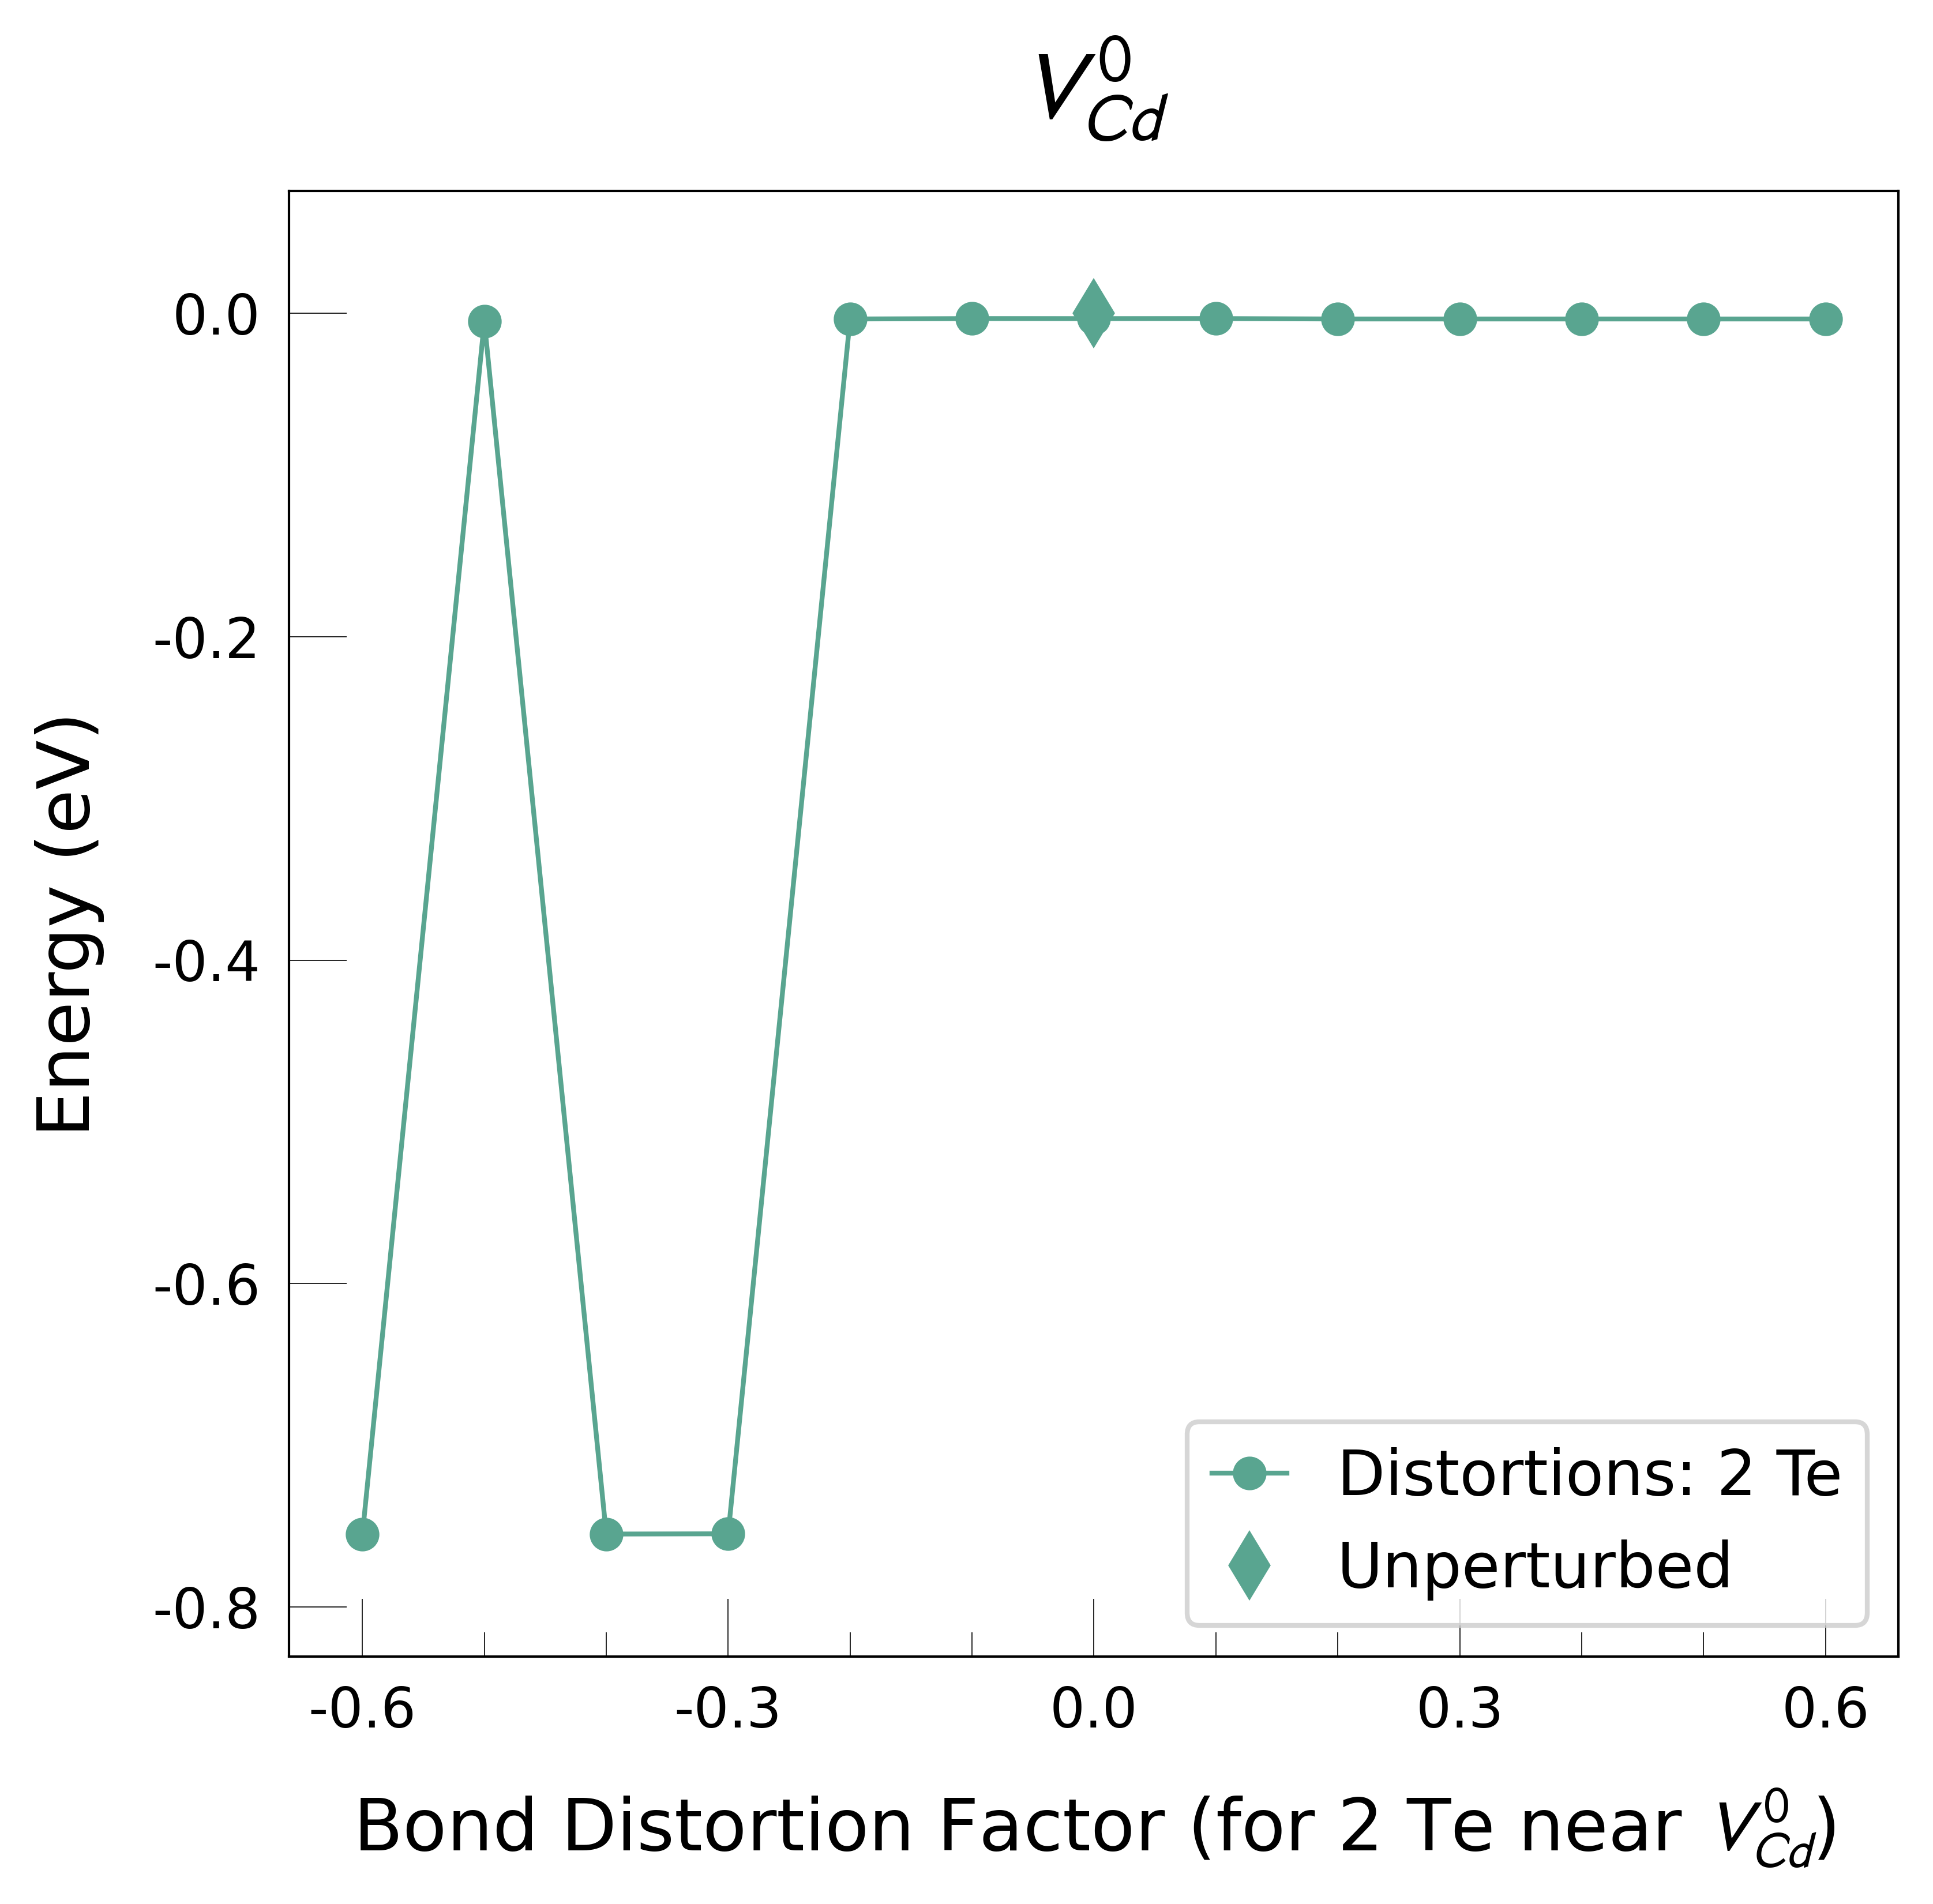

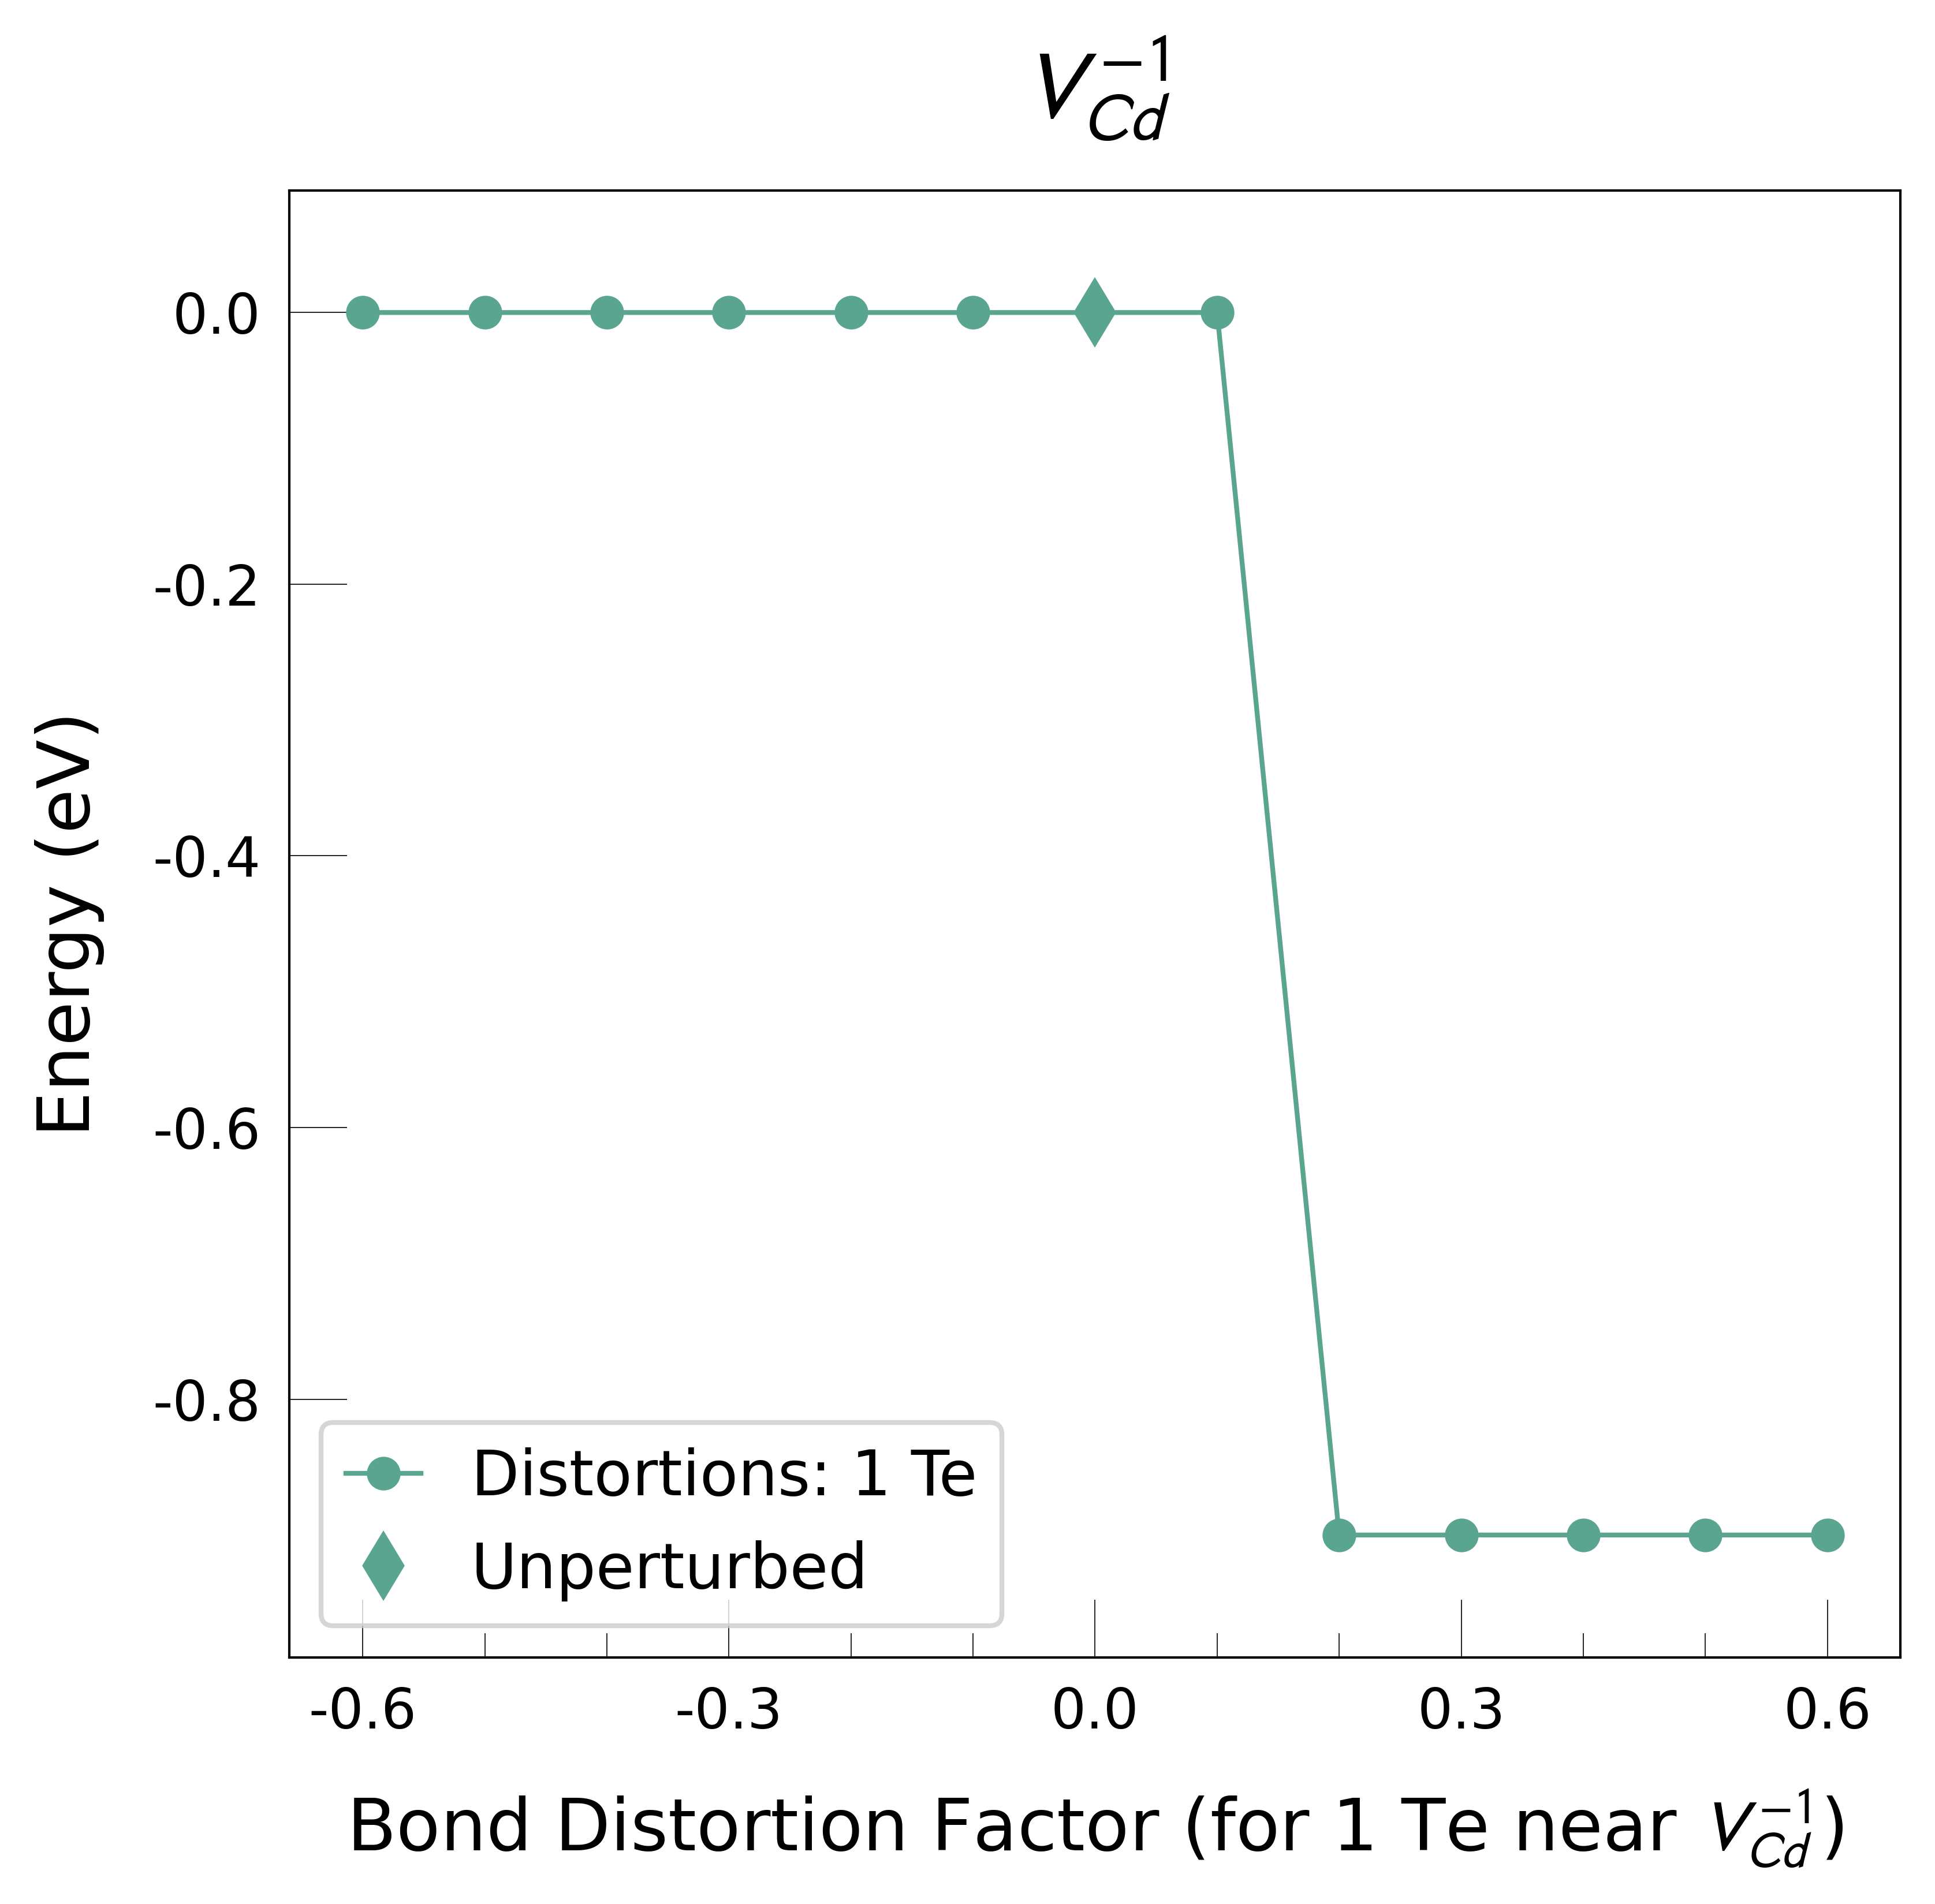

In [17]:
figs = plotting.plot_all_defects(defect_charges_dict)

This prints the distortion plots for all defects where a significant energy lowering distortion, relative to the standard unperturbed relaxation, was identified. The threshold energy difference to consider as 'significant' is controlled by the `min_e_diff` optional parameter (default = 0.05 eV).

### Can also add a colorbar 
These plots can be made more informative by adding a colorbar showing the structural similarity between the relaxed structures.   
For this you need the `CONTCAR`'s obtained with each distortion (as mentioned above).

For the colorbar structure comparison metric, you can either use:
* summed root mean squared displacement (`metric` = `disp`)
* maximum distance between matching sites (`metric` = `max_dist`, default).   

Energy lowering distortion found for v_Cd_s0 with charge 0. Generating distortion plot...
Comparing structures to Unperturbed...
Plot saved to v_Cd_s0_0/v_Cd_s0_0.png
Energy lowering distortion found for v_Cd_s0 with charge -1. Generating distortion plot...
Comparing structures to Unperturbed...
Plot saved to v_Cd_s0_-1/v_Cd_s0_-1.png


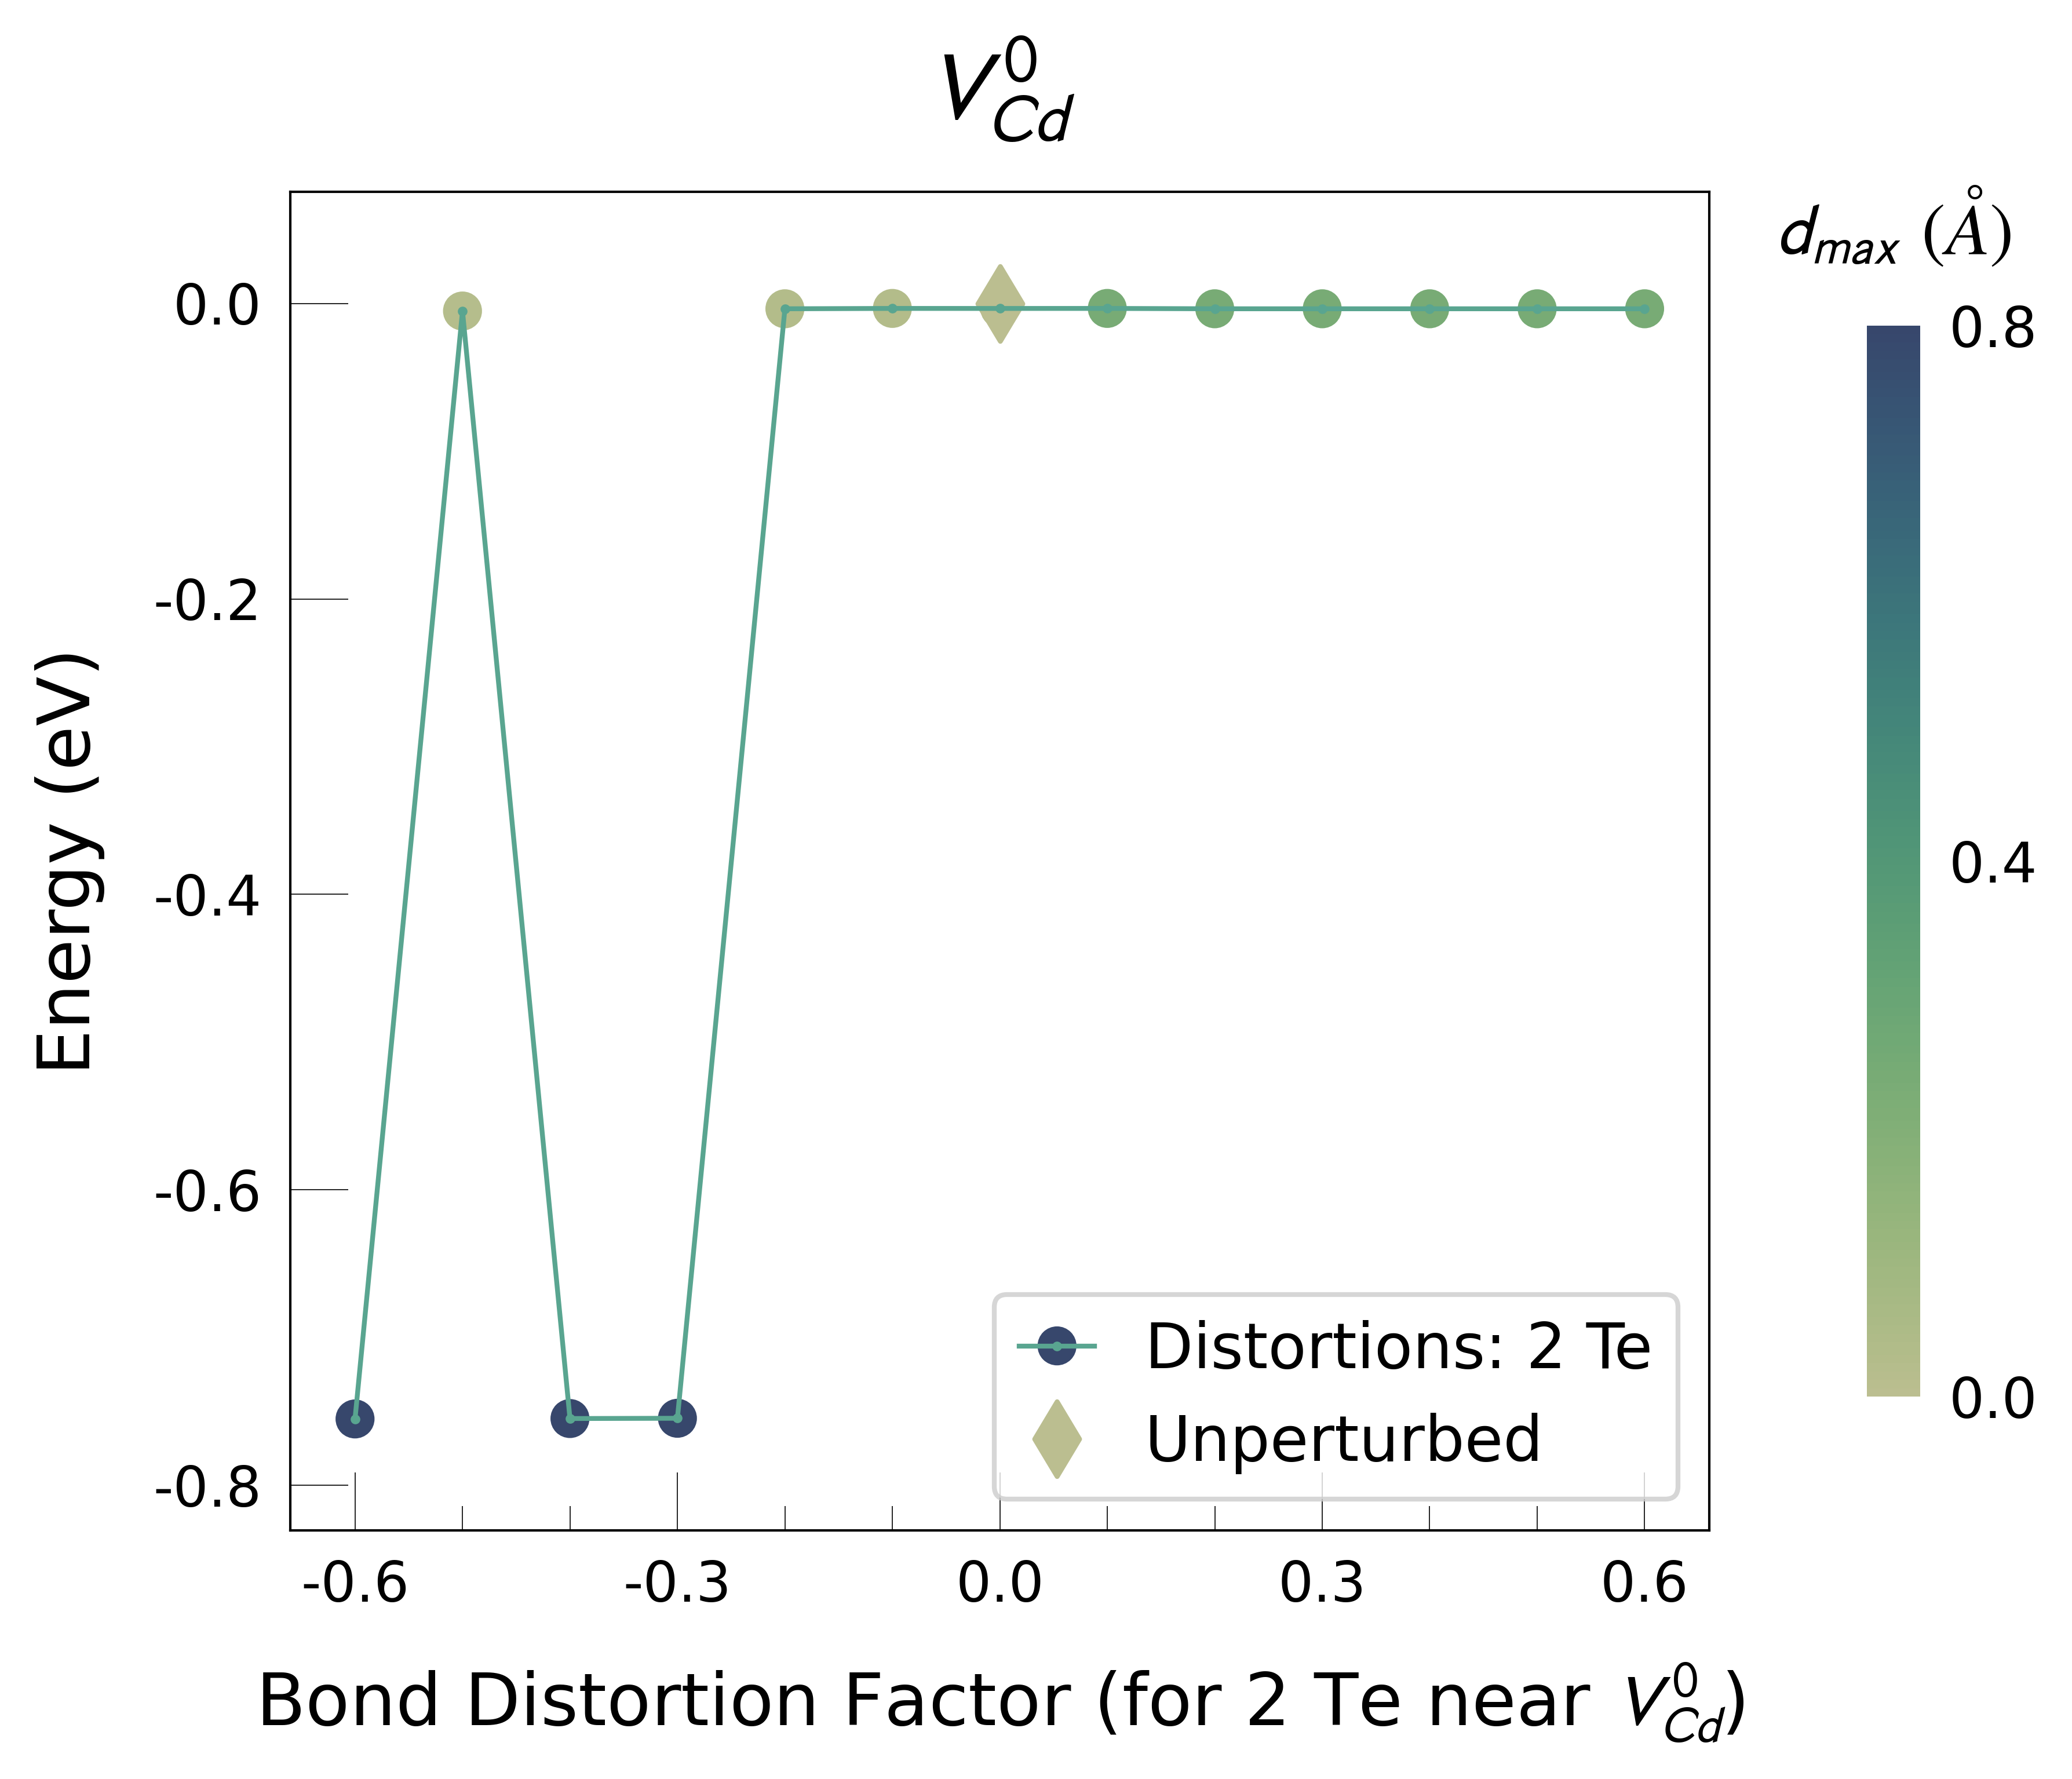

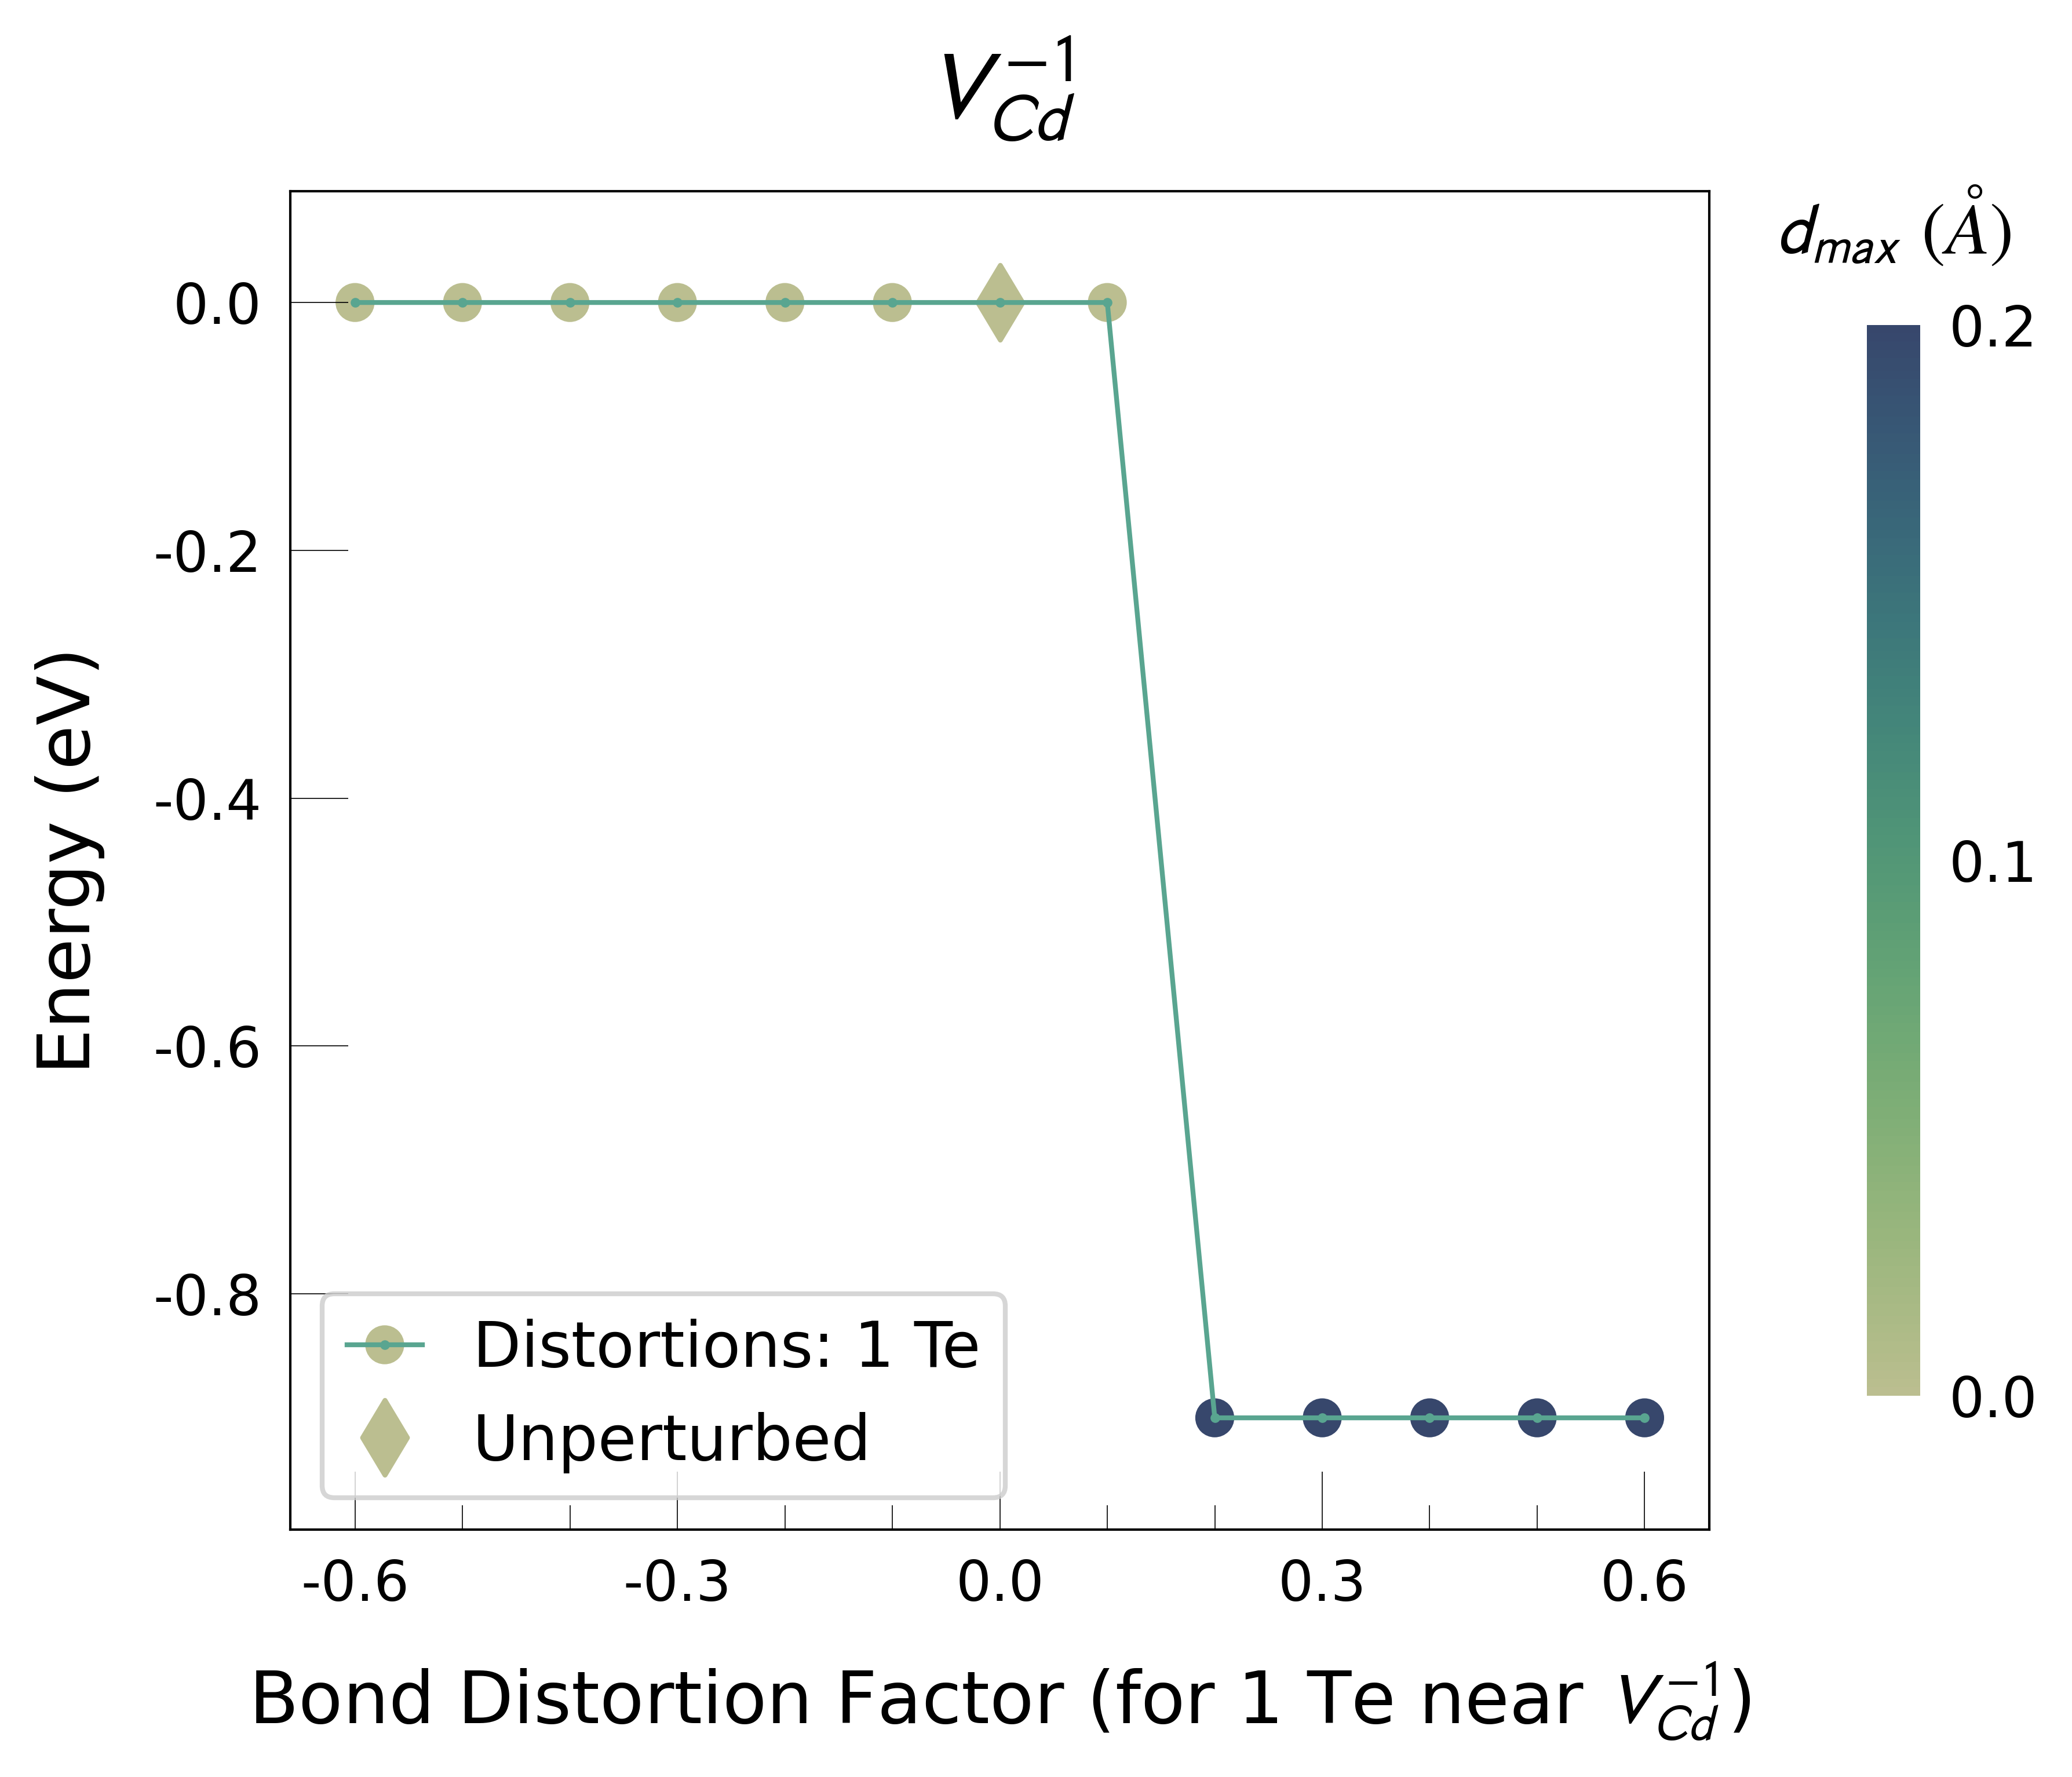

In [18]:
figs = plotting.plot_all_defects(
    defect_charges_dict,
    add_colorbar=True
)

Energy lowering distortion found for v_Cd_s0 with charge 0. Generating distortion plot...
Comparing structures to Unperturbed...
Plot saved to v_Cd_s0_0/v_Cd_s0_0.png
Energy lowering distortion found for v_Cd_s0 with charge -1. Generating distortion plot...
Comparing structures to Unperturbed...
Plot saved to v_Cd_s0_-1/v_Cd_s0_-1.png


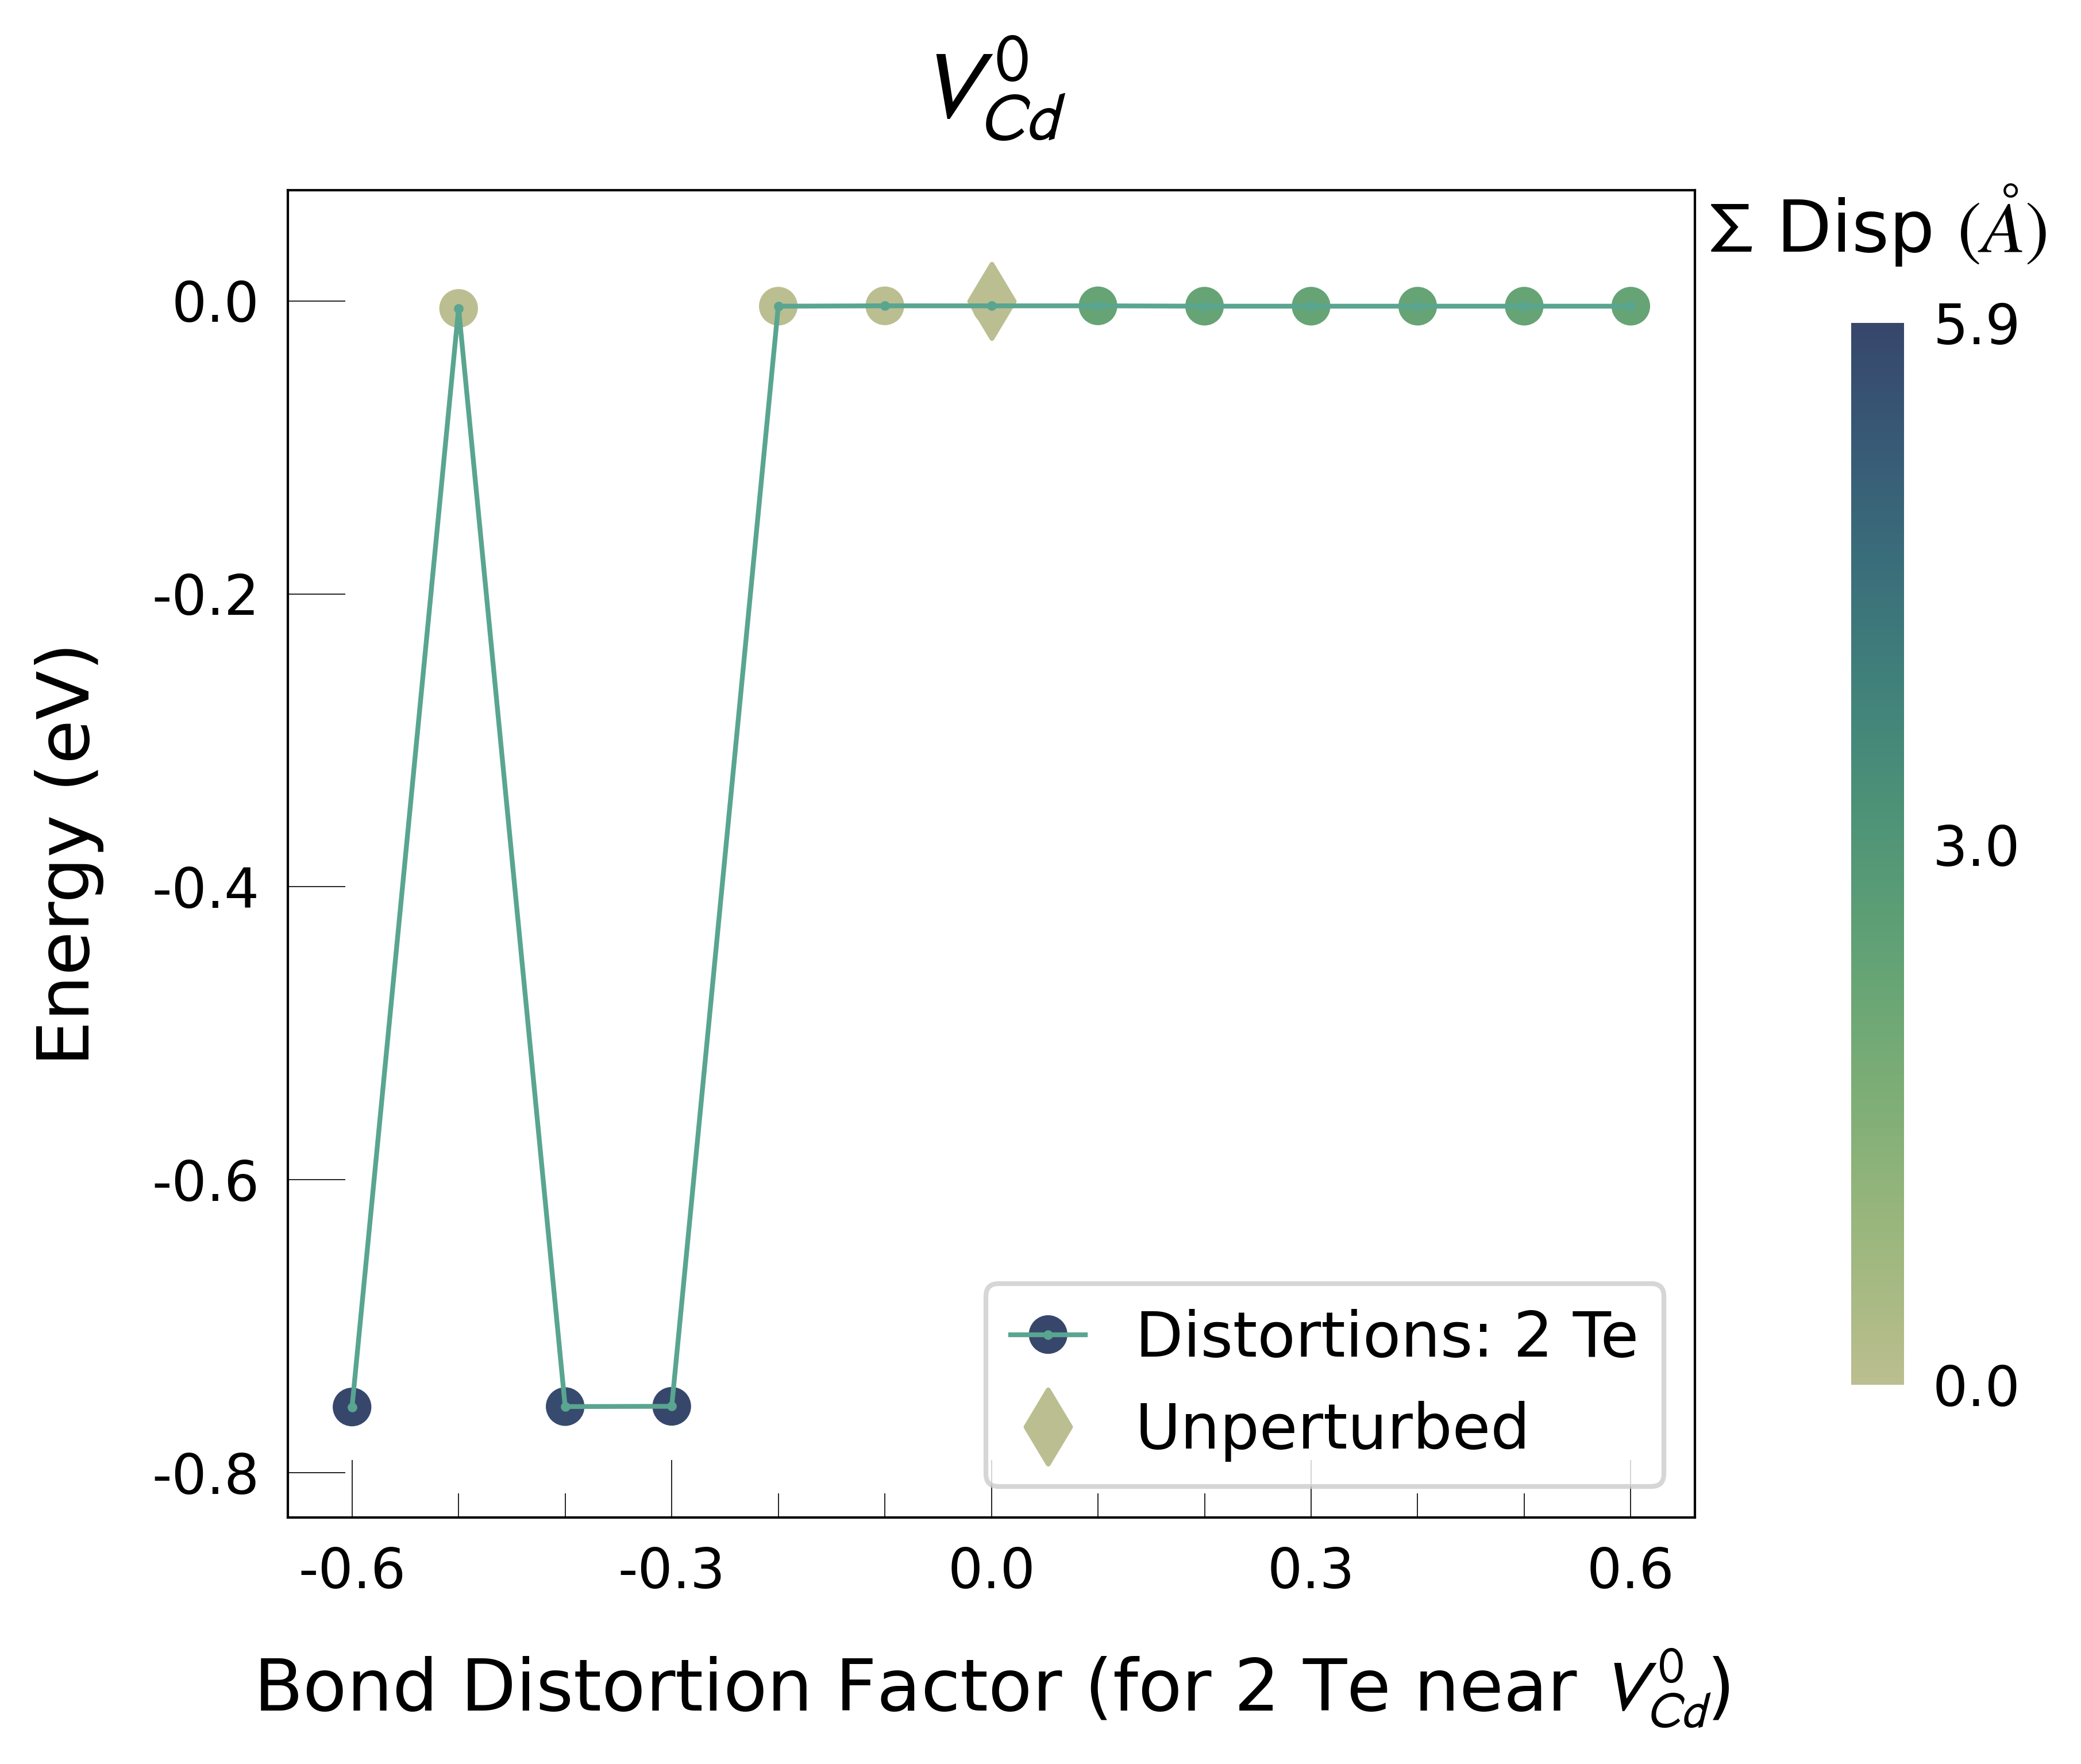

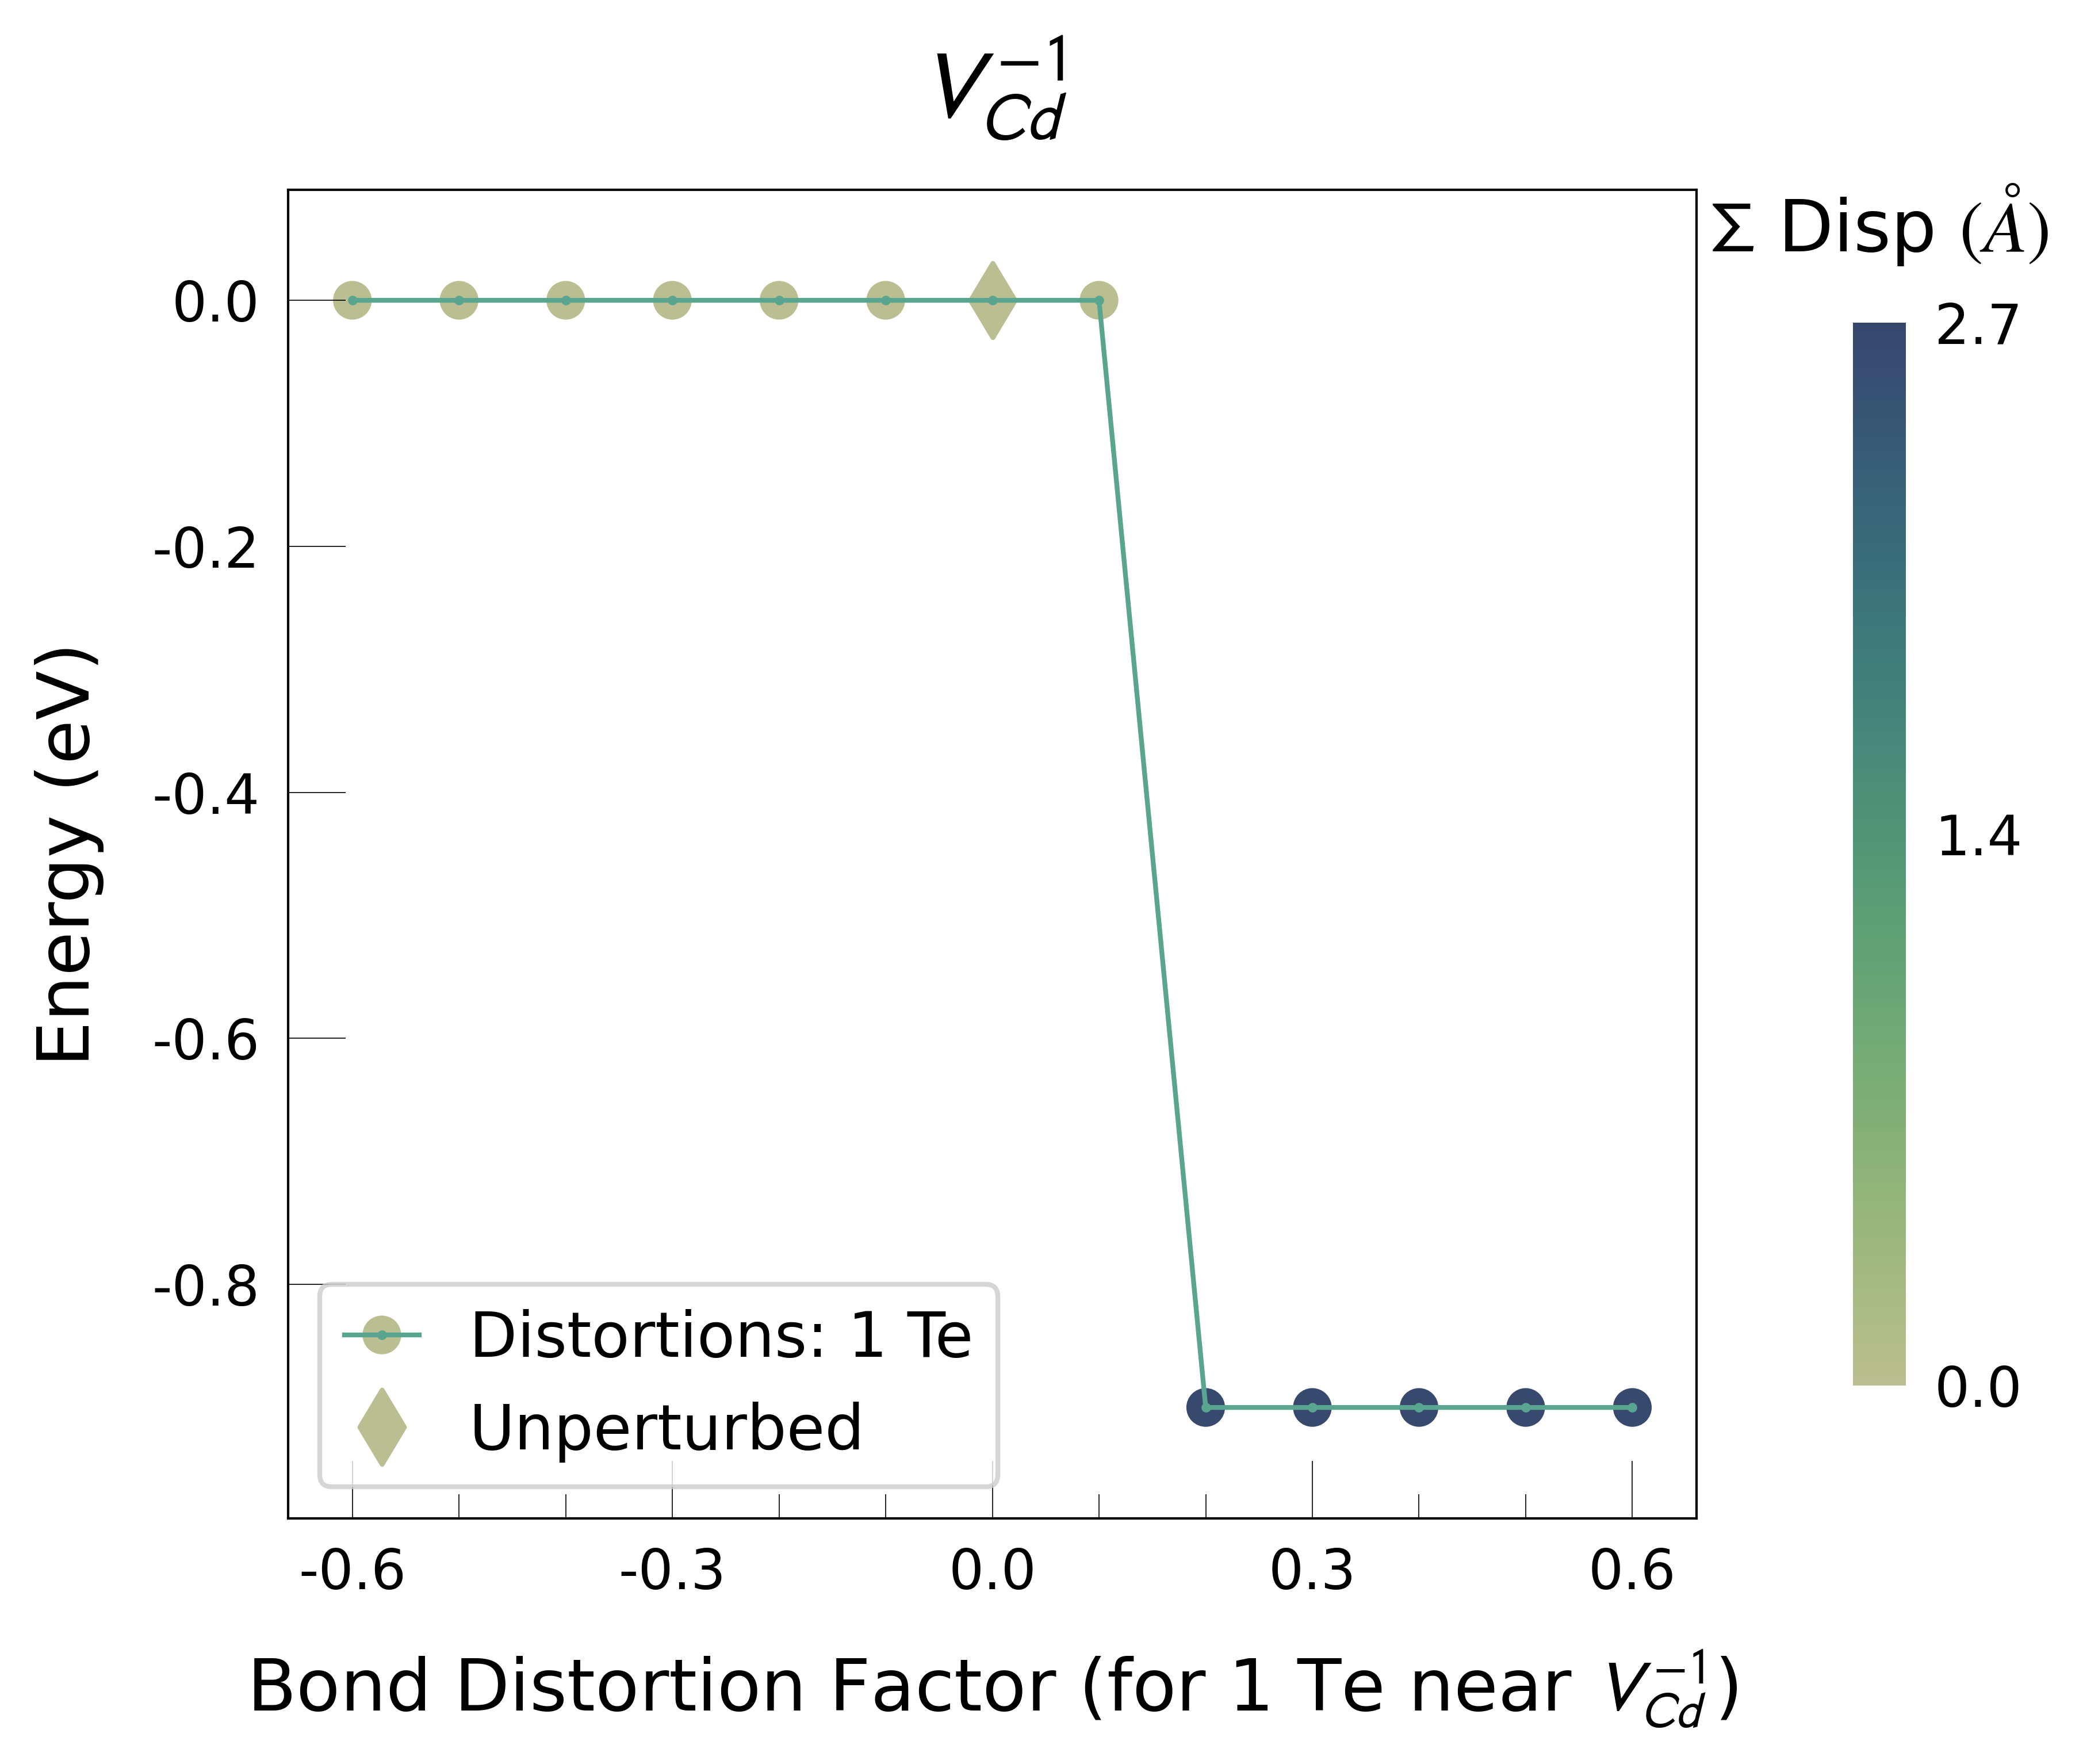

In [19]:
figs = plotting.plot_all_defects(
    defect_charges_dict,
    add_colorbar=True,
    metric="disp"
)

So for these example results, we find energy lowering distortions for V<sub>Cd</sub><sup>0</sup> (at -0.3, -0.4 and -0.6 bond distortion factors) and V<sub>Cd</sub><sup>-1</sup> (from 0.2 to 0.6 bond distortion factors). We should re-test these distorted structures for the V<sub>Cd</sub> charge states where these distortions were not found, in case they also give lower energies. 

Of course, this is not necessary if these structures were already found in the distortion tests for the other charge states, and so the `get_energy_lowering_distortions()` function automatically performs structure comparisons to determine which distortions should be tested in other charge states of the same defect, and which have already been found (see docstring for more details). 

In the output of `get_energy_lowering_distortions()` (which we saved to `low_energy_defects` in the earlier cell), we get a dictionary of defects for which bond distortion found an energy-lowering distortion (which is missed with normal unperturbed relaxation), of the form {defect: [list of distortion dictionaries (with corresponding charge states, energy lowering, distortion factors, structures and charge states for which these structures weren't found)]}.

For example, our results with V<sub>Cd</sub> show that we found an energy-lowering distortion for the neutral case (`subdict["charges"]`) which wasn't found with the -2 or -1 charge states (`subdict["excluded_charges"]`) – and so we'll test this distorted structures with those charge states – and also an energy-lowering distortion for -1 which wasn't found with 0 or -2 charge states.

In [20]:
for index, subdict in enumerate(low_energy_defects["v_Cd_s0"]):
    print(f"Energy lowering distortion number {index}")
    print("Found for charge states:", subdict["charges"])  # Charge state for which the energy lowering was found
    print(f"Not found in:", subdict["excluded_charges"], "\n")

Energy lowering distortion number 0
Found for charge states: [0]
Not found in: {-2, -1} 

Energy lowering distortion number 1
Found for charge states: [-1]
Not found in: {0, -2} 



This generates the new distorted structures and VASP inputs, to do our quick second round of structure testing (energy-lowering distortions found for at least one, but not all charge states for a given defect):

In [21]:
energy_lowering_distortions.write_retest_inputs(low_energy_defects)

Writing low-energy distorted structure to ./v_Cd_s0_-2/Bond_Distortion_-60.0%_from_0
No subfolders with VASP input files found in ./v_Cd_s0_-2, so just writing distorted POSCAR file to ./v_Cd_s0_-2/Bond_Distortion_-60.0%_from_0 directory.
Writing low-energy distorted structure to ./v_Cd_s0_-1/Bond_Distortion_-60.0%_from_0
No subfolders with VASP input files found in ./v_Cd_s0_-1, so just writing distorted POSCAR file to ./v_Cd_s0_-1/Bond_Distortion_-60.0%_from_0 directory.
Writing low-energy distorted structure to ./v_Cd_s0_0/Bond_Distortion_20.0%_from_-1
No subfolders with VASP input files found in ./v_Cd_s0_0, so just writing distorted POSCAR file to ./v_Cd_s0_0/Bond_Distortion_20.0%_from_-1 directory.
Writing low-energy distorted structure to ./v_Cd_s0_-2/Bond_Distortion_20.0%_from_-1
No subfolders with VASP input files found in ./v_Cd_s0_-2, so just writing distorted POSCAR file to ./v_Cd_s0_-2/Bond_Distortion_20.0%_from_-1 directory.


```{Note}
Note here the nomenclature we use for the distorted structures we've imported from other charge states (i.e. `Bond_Distortion_-60.0%_from_0` refers to the structure obtained from relaxing the -60% distortion of the neutral (q = 0) charge state).
```

We can send these additional test distortions to the HPCs using this `bash` code:
```bash
for defect in ./*{_,_-}[0-9]/; do cd $defect; for distortion in *from*/; do scp -r ${distortion} {remote_machine}:{path to ShakeNBreak folders}/${defect}${distortion}; done; cd ..; done
```
If you're using MacOS (i.e. `zsh` shell) you may need to run this command first for this loop to work:
```bash
setopt +o nomatch
```

Again we run the calculations on the HPCs, then parse and download the data to our local folders (e.g. using the same `for` loops above), but again in this example notebook we'll use our fake example data **_for demonstration purposes_** as in the next cell, but don't do this if you're actually running the calculations!

In [22]:
!cp ./v_Cd_s0_0/v_Cd_s0_0_additional_distortions.yaml ./v_Cd_s0_0/v_Cd_s0_0.yaml
!cp ./v_Cd_s0_-1/v_Cd_s0_-1_additional_distortions.yaml ./v_Cd_s0_-1/v_Cd_s0_-1.yaml
!cp ./v_Cd_s0_-2/v_Cd_s0_-2_additional_distortions.yaml ./v_Cd_s0_-2/v_Cd_s0_-2.yaml
!cp ./v_Cd_s0_0/Bond_Distortion_-60.0%/CONTCAR ./v_Cd_s0_-1/Bond_Distortion_-60.0%_from_0/
!cp ./v_Cd_s0_0/Bond_Distortion_-60.0%/CONTCAR ./v_Cd_s0_-2/Bond_Distortion_-60.0%_from_0/
!cp ./v_Cd_s0_-1/Unperturbed/CONTCAR ./v_Cd_s0_-2/Bond_Distortion_20.0%_from_-1/
!cp ./v_Cd_s0_-1/Unperturbed/CONTCAR ./v_Cd_s0_0/Bond_Distortion_20.0%_from_-1/

Then re-parse with the same `get_energy_lowering_distortions()` function from before:

In [23]:
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict)


v_Cd_s0
Parsing v_Cd_s0_-2...
v_Cd_s0_-2: Energy difference between minimum, found with 20.0%_from_-1 bond distortion, and unperturbed: -1.90 eV.
Energy lowering distortion found for v_Cd_s0 with charge -2. Adding to low_energy_defects dictionary.
Parsing v_Cd_s0_0...
v_Cd_s0_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
New (according to structure matching) low-energy distorted structure found for v_Cd_s0_0, adding to low_energy_defects['v_Cd_s0'] list.
Parsing v_Cd_s0_-1...
v_Cd_s0_-1: Energy difference between minimum, found with -60.0%_from_0 bond distortion, and unperturbed: -1.20 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...
Low-energy distorted structure for v_Cd_s0_-1 already found with charge states [0], storing together.

Comparing and pruning defect structures across charge stat

Finally we can replot the results from all our distortion tests:

Energy lowering distortion found for v_Cd_s0 with charge -2. Generating distortion plot...
Plot saved to v_Cd_s0_-2/v_Cd_s0_-2.png
Energy lowering distortion found for v_Cd_s0 with charge 0. Generating distortion plot...
Plot saved to v_Cd_s0_0/v_Cd_s0_0.png
Energy lowering distortion found for v_Cd_s0 with charge -1. Generating distortion plot...
Plot saved to v_Cd_s0_-1/v_Cd_s0_-1.png


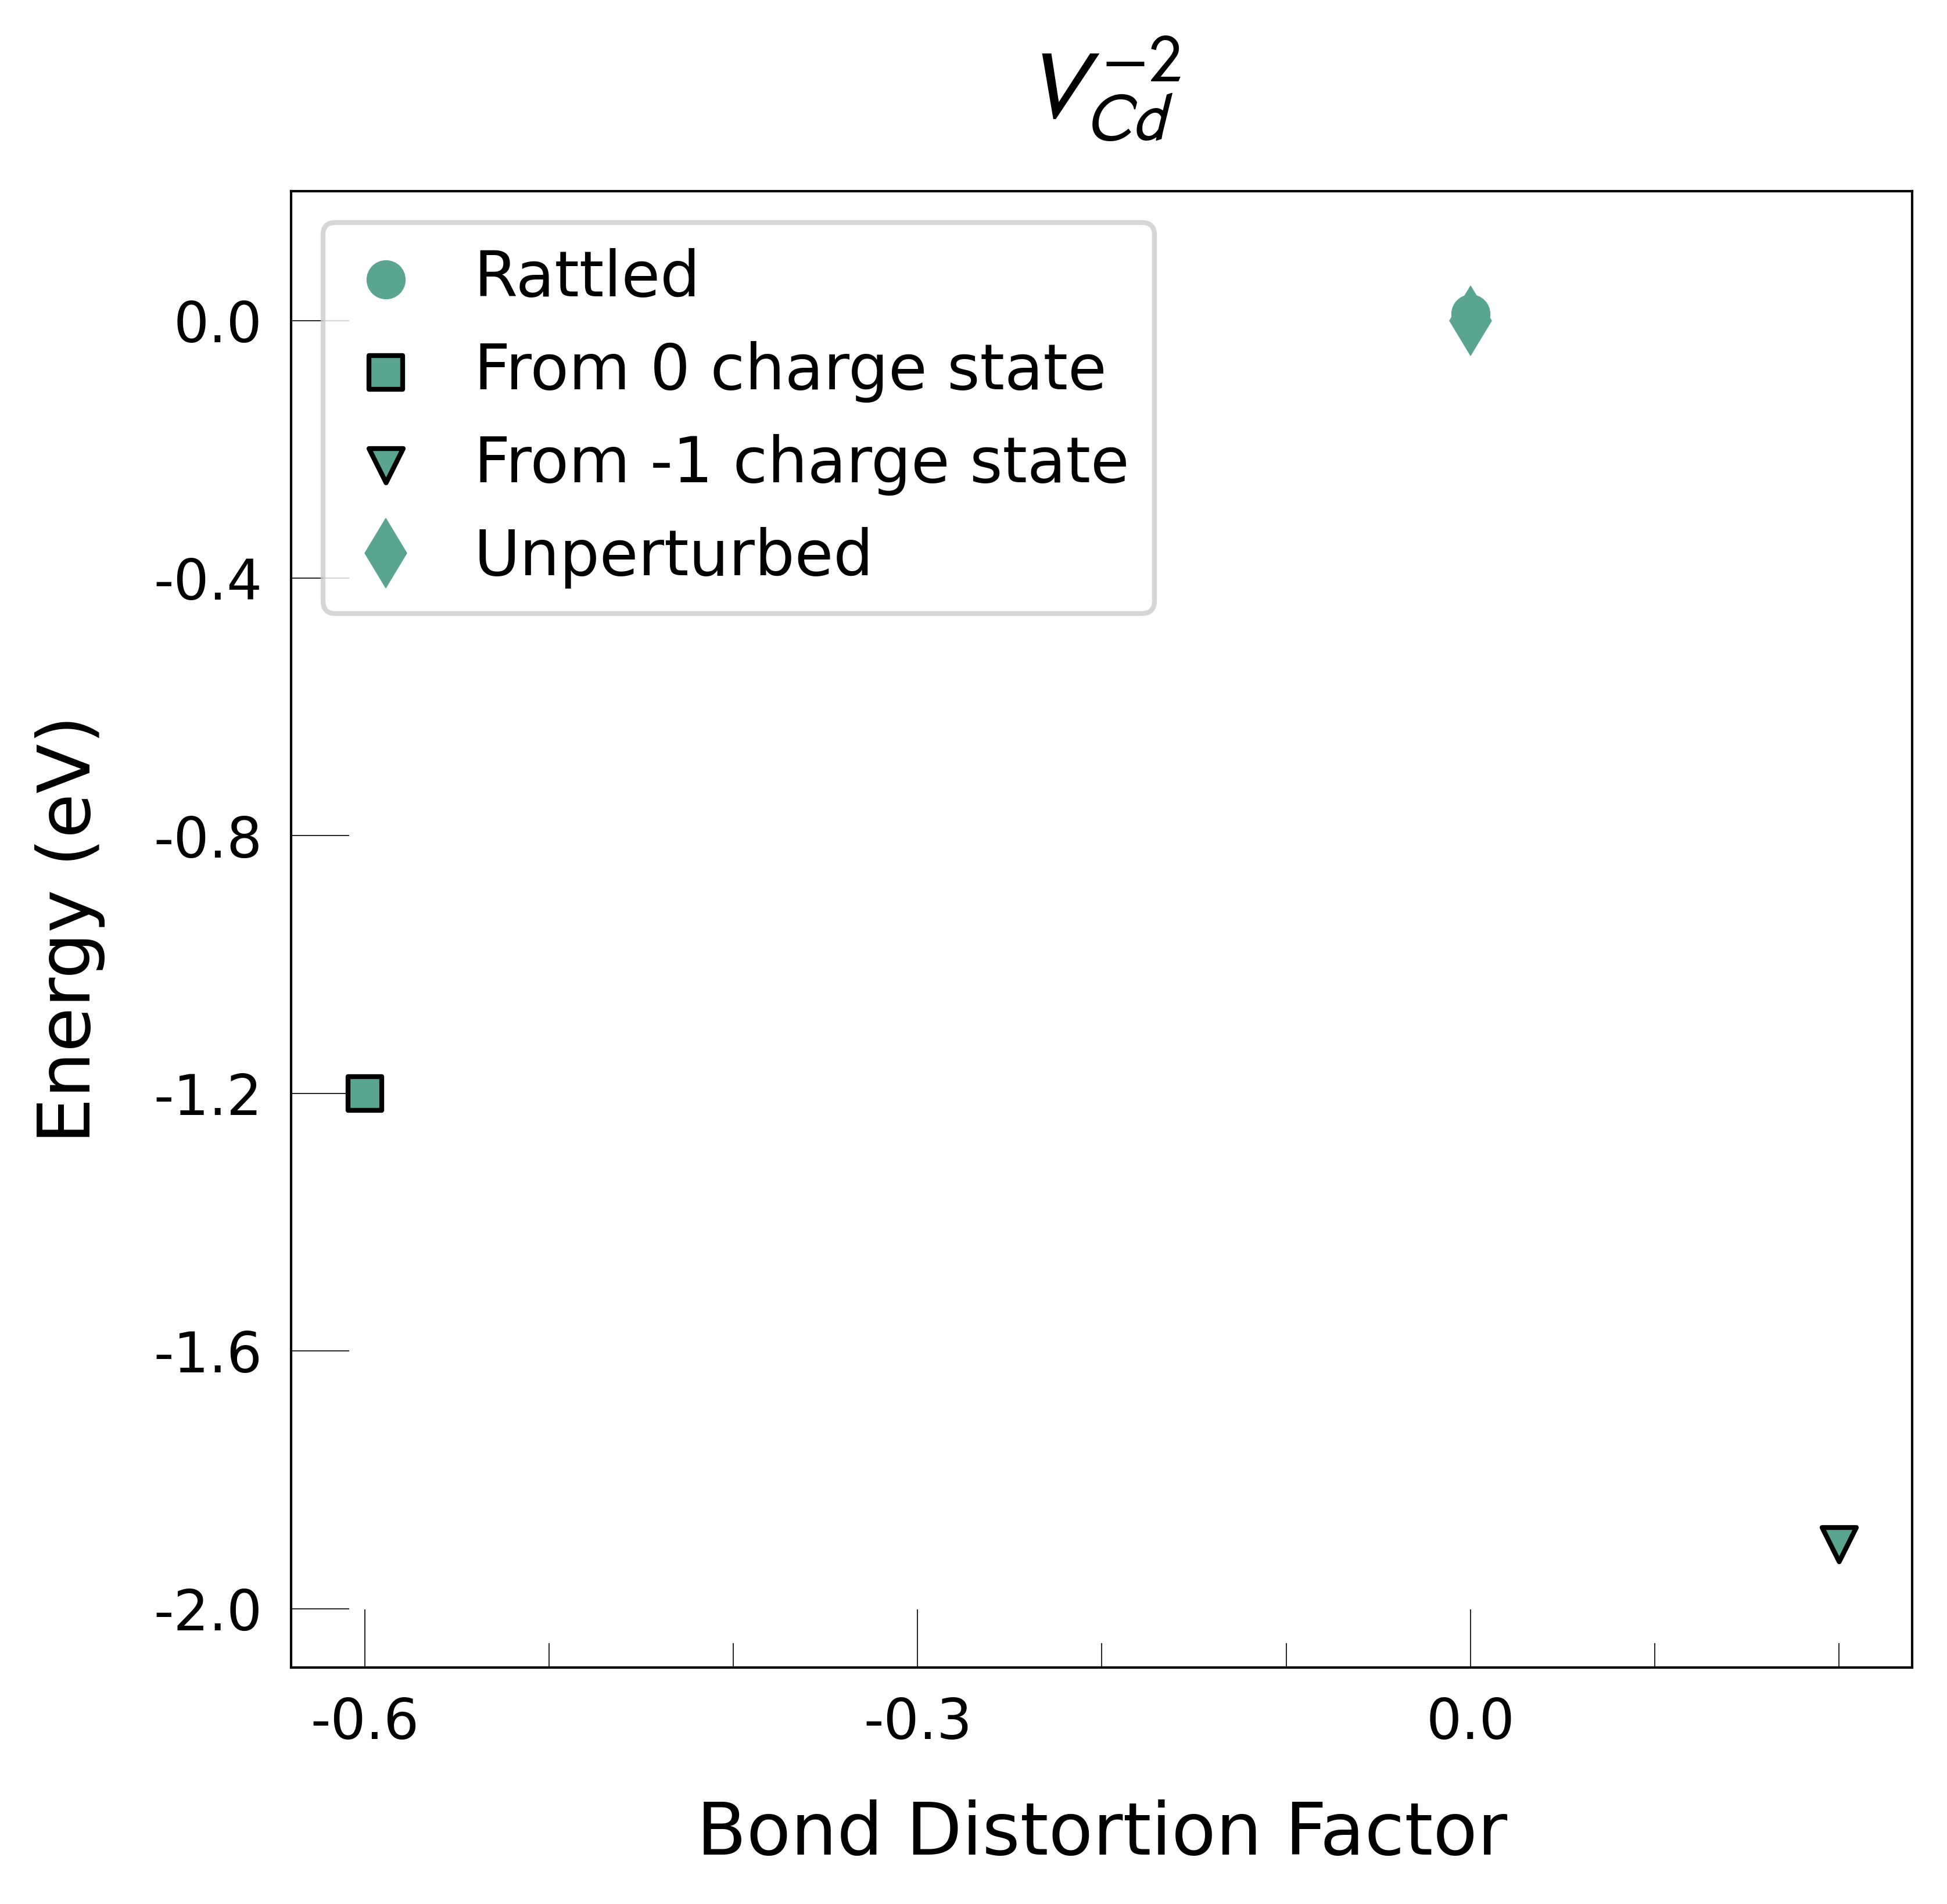

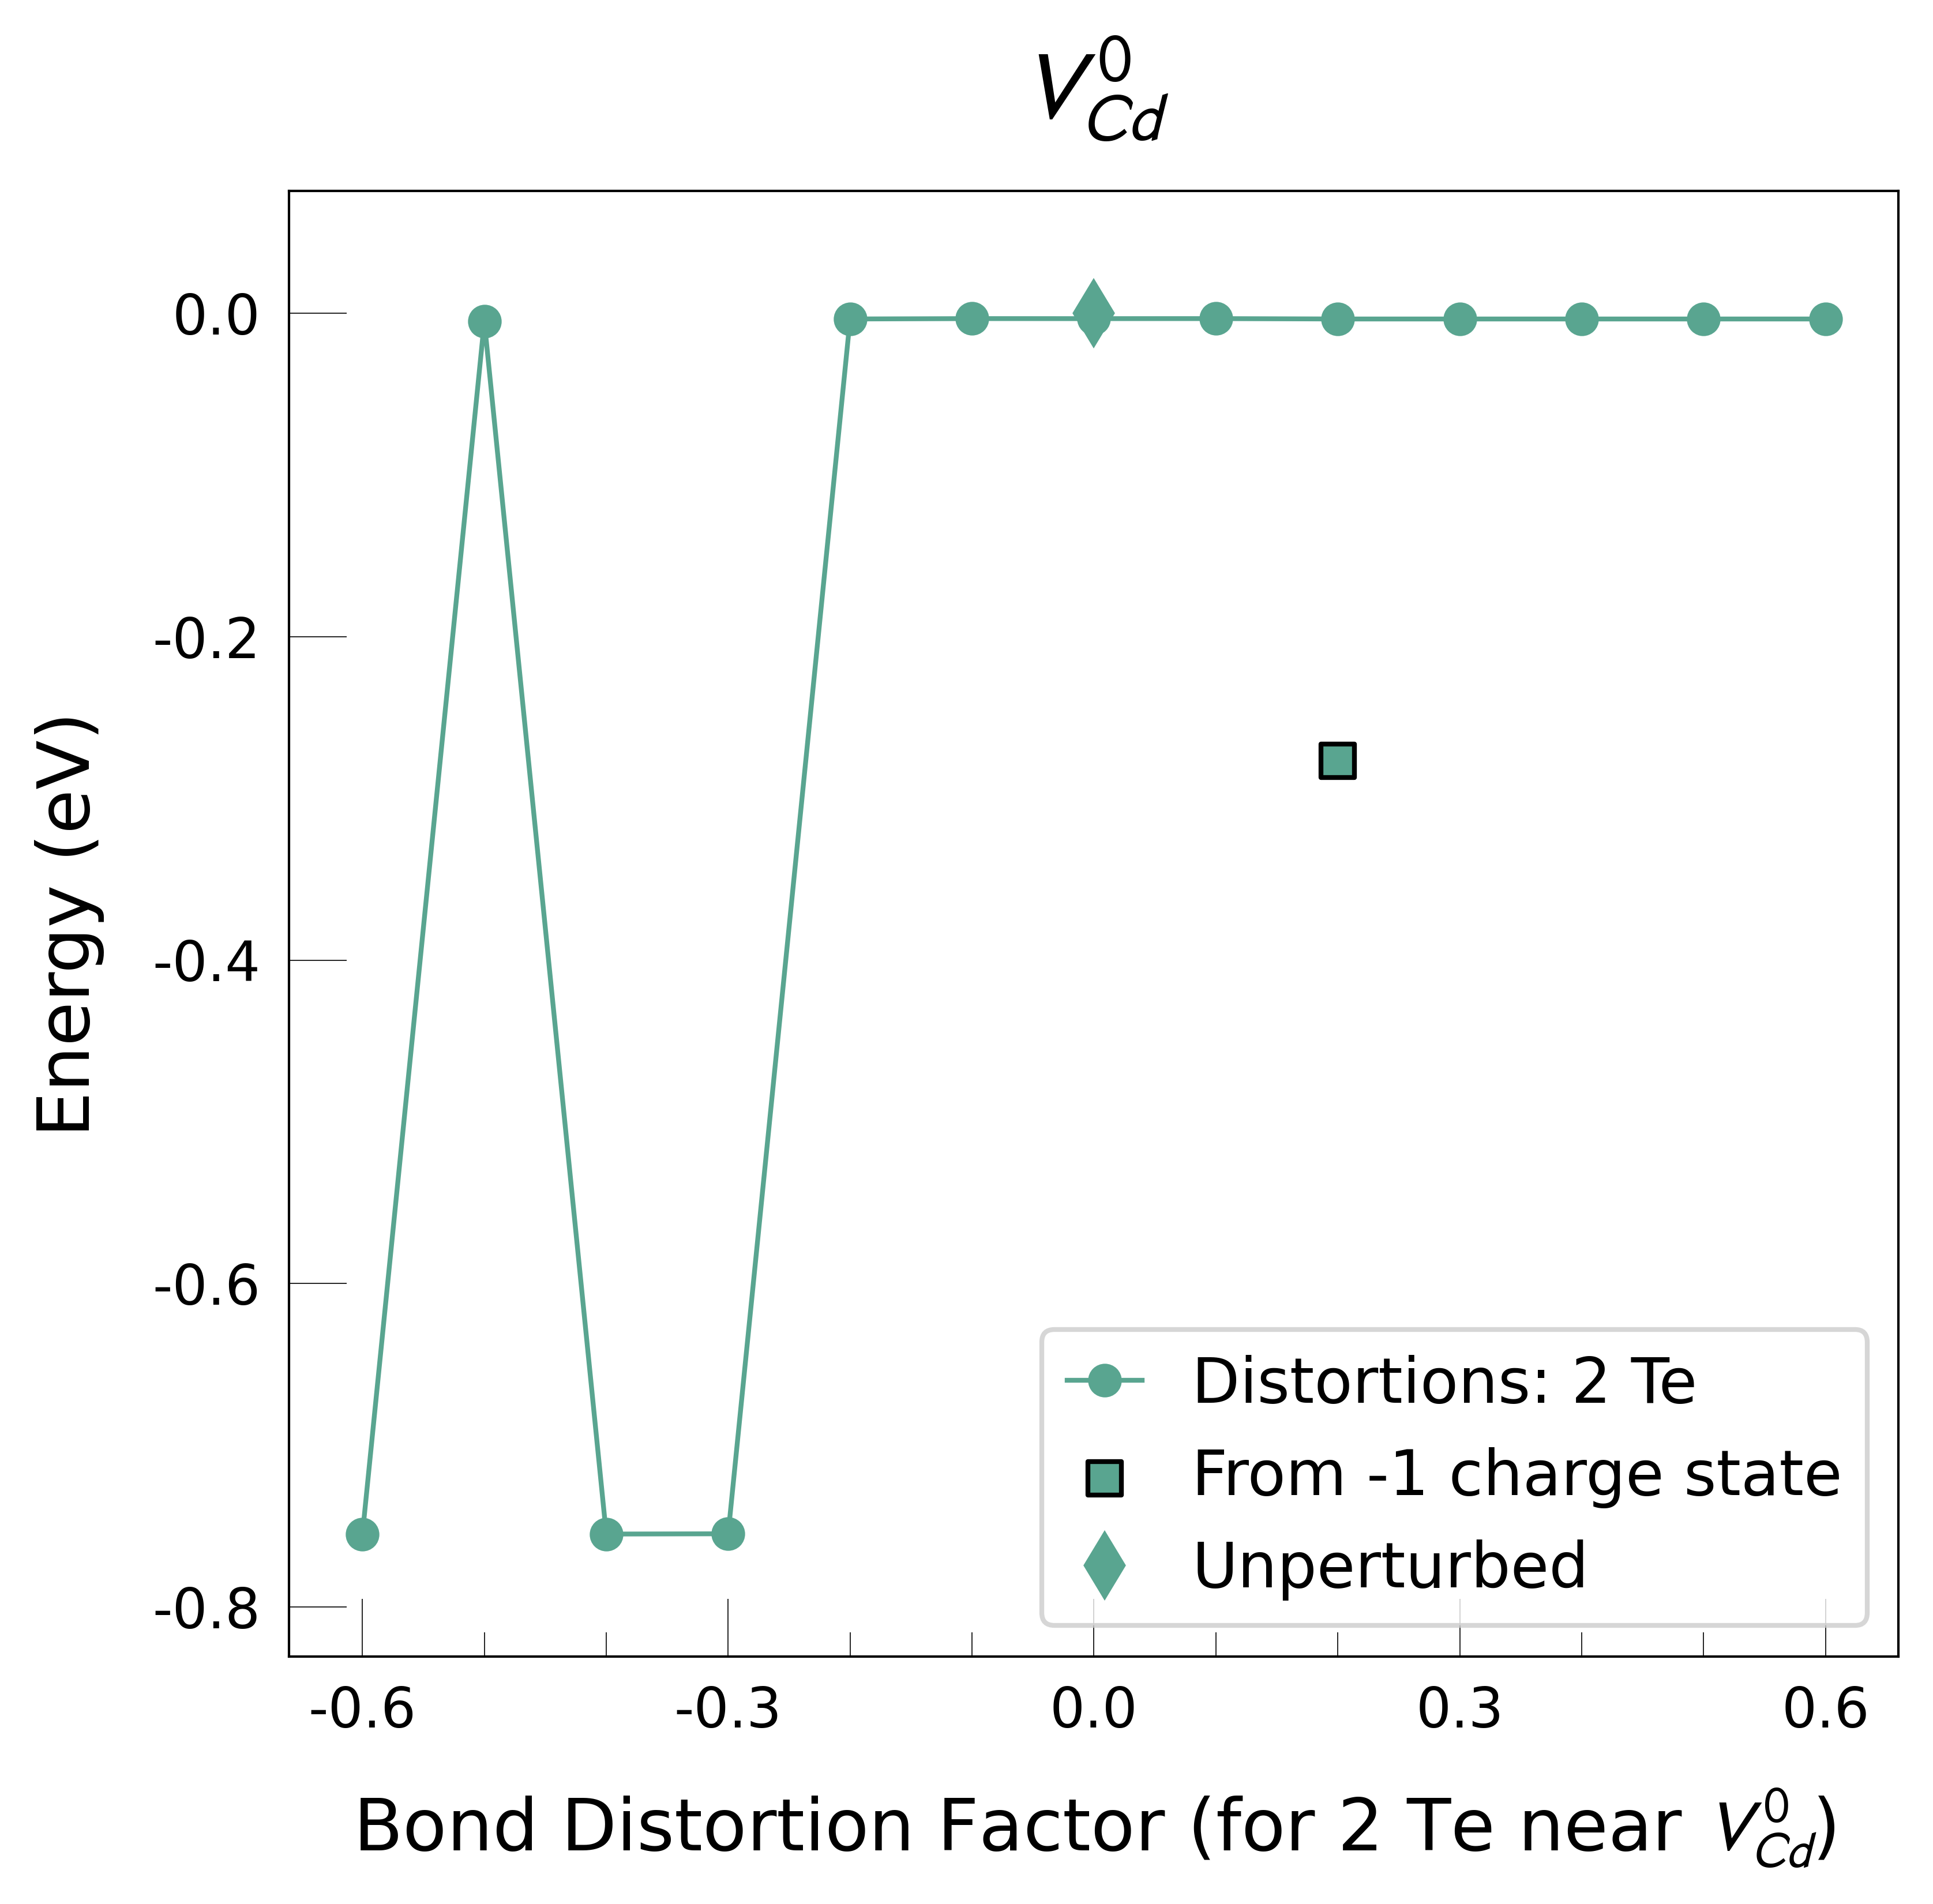

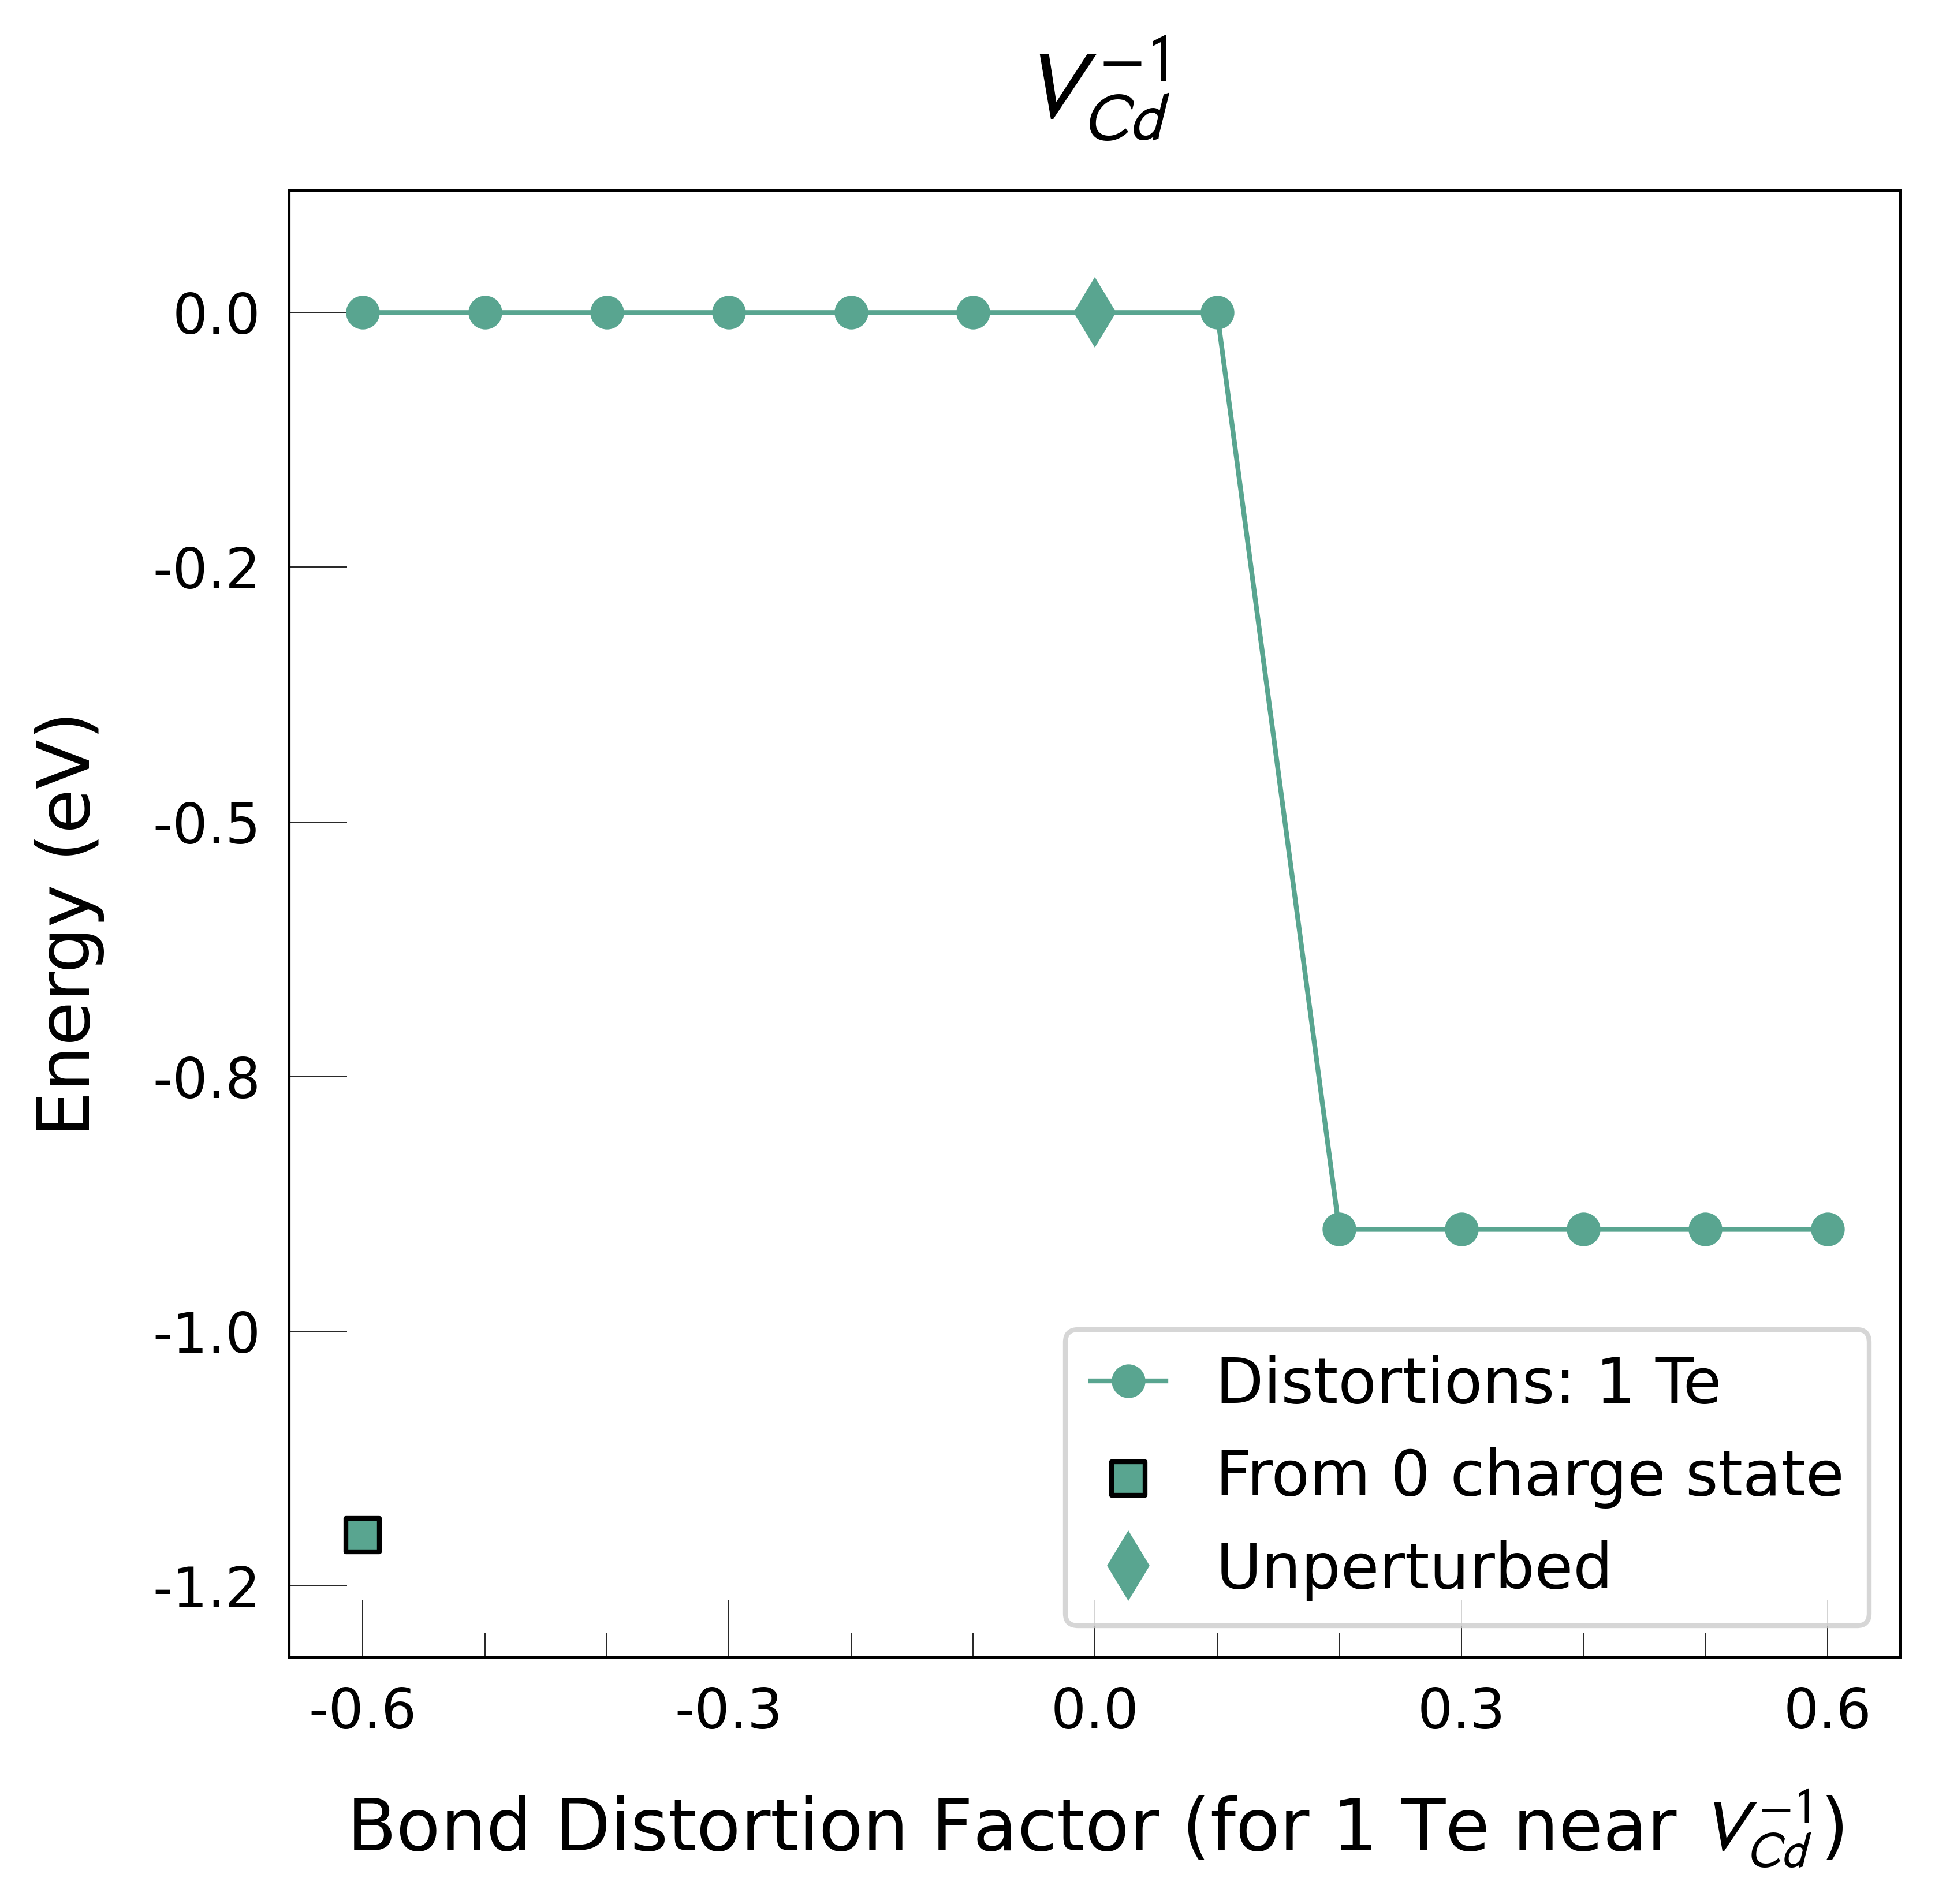

In [24]:
figs = plotting.plot_all_defects(defect_charges_dict)

In this example case, for V<sub>Cd</sub><sup>0</sup> the distorted structure originally found for the -1 charge state comes out lower energy than the V<sub>Cd</sub><sup>0</sup> unperturbed relaxation, but still higher energy than the previously identified ground-state at -0.3, -0.4 and -0.6 distortion factors. 

For V<sub>Cd</sub><sup>-1</sup>, the distorted structure originally found for the neutral (0) charge state comes out lower energy than the previously identified ground-state at distortion factors >0.2.

We now continue our defect calculations using the ground-state `CONTCAR`s we've obtained for each defect, with our fully-converged `INCAR` and `KPOINTS` settings, to get our final defect formation energies (confident that we've identified the ground-state defect structure!). The `energy_lowering_distortions.write_groundstate_structure()` function automatically writes these lowest-energy structures to our defect folders:

In [25]:
energy_lowering_distortions.write_groundstate_structure()

In [26]:
!head v_Cd_s0_0/groundstate_POSCAR  # groundstate structure from -60% distortion relaxation

-60.0%_Bond__vac_1_Cd[0. 0. 0.]_-dNELECT
   1.0000000000000000     
    13.0867679999999993    0.0000000000000000    0.0000000000000000
     0.0000000000000000   13.0867679999999993    0.0000000000000000
     0.0000000000000000    0.0000000000000000   13.0867679999999993
   Cd   Te
    31    32
Direct
  0.0014403846070577  0.0152341826280604  0.4960600473735149
  0.0018443102488570  0.5161087673464303 -0.0040398656877614


In [27]:
!diff v_Cd_s0_0/groundstate_POSCAR v_Cd_s0_0/Bond_Distortion_-60.0%/CONTCAR  # groundstate structure from -60% distortion relaxation

## 5. *Optional*: Analyse the defect distortions found with `SnB`

If we want to analyse in more detail the defect distortions identified with our structure searching, we can use some of the functions from `shakenbreak.analysis`:

In [28]:
from shakenbreak import analysis

# Parse all structures obtained with distortions and unperturbed relaxation.   
# This gives a dictionary matching initial distortion to final structure
v_Cd_s0_0 = analysis.get_structures("v_Cd_s0_0")

In [29]:
# Can then analyse a chosen final structure with:
df = analysis.analyse_structure("v_Cd_s0_0", v_Cd_s0_0["Unperturbed"])
df = analysis.analyse_structure("v_Cd_s0_0", v_Cd_s0_0[-0.4])

v_Cd_s0_0 structural analysis 
Analysing site V [0. 0. 0.]
Local order parameters (i.e. resemblance to given structural motif, via CrystalNN):


,Coordination,Factor
0,square co-planar,0.09
1,tetrahedral,1.00
2,rectangular see-saw-like,0.01
3,see-saw-like,0.24
4,trigonal pyramidal,0.25



Bond-lengths (in Å) to nearest neighbours: 


,Element,Distance (Å)
0,Te,2.60
1,Te,2.63
2,Te,2.63
3,Te,2.65



v_Cd_s0_0 structural analysis 
Analysing site V [0. 0. 0.]
Local order parameters (i.e. resemblance to given structural motif, via CrystalNN):


,Coordination,Factor
0,square co-planar,0.13
1,tetrahedral,0.74
2,rectangular see-saw-like,0.03
3,see-saw-like,0.21
4,trigonal pyramidal,0.21



Bond-lengths (in Å) to nearest neighbours: 


,Element,Distance (Å)
0,Te,2.19
1,Te,2.63
2,Te,2.64
3,Te,2.30


We can also compare the structural similarity between all structures with `compare_structures()`. It prints the summed root mean squared displacement,
maximum distance between paired sites, and energy (relative to unperturbed structure) of all final structures:

In [30]:
defect_energies = analysis.get_energies("v_Cd_s0_0")
structure_comparison = analysis.compare_structures(
    v_Cd_s0_0,
    defect_energies
)

v_Cd_s0_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Comparing structures to Unperturbed...


,Bond Distortion,Σ{Displacements} (Å),Max Distance (Å),Δ Energy (eV)
0,-0.6,5.873,0.810,-0.76
1,-0.5,0.000,0.024,-0.01
2,-0.4,5.760,0.808,-0.75
3,-0.3,5.872,0.808,-0.75
4,-0.2,0.000,0.025,0.00
5,-0.1,0.000,0.028,0.00
6,0.0,0.000,0.030,0.00
7,0.1,2.285,0.237,0.00
8,0.2,2.285,0.237,0.00
9,0.3,2.285,0.237,0.00


Highly favourable distortions are often driven by some kind of rebonding. For most vacancies and interstitials, this entails formation of new homoionic bonds between the defect neighbours.
We can quickly check for these reconstructions using `analysis.get_homoionic_bonds()`

In [31]:
bonds = analysis.get_homoionic_bonds(
    structure=v_Cd_s0_0[-0.4], # Structure to analyse
    element="Te", # we're looking for Te-Te bonds
    radius=2.8, # maximum bond distance between 2 Te
    verbose=False, # don't print bond distances
)
print(bonds)
print("So two of the vacancy neighbours formed a Te-Te bond to compensate for the charge deficiency")

{'Te(32)': {'Te(41)': '2.75 A'}}
So two of the vacancy neighbours formed a Te-Te bond to compensate for the charge deficiency


For defects that can result in polarons, we can check the sites with significant magnetization using `analysis.get_site_magnetizations()`

In [32]:
!cp -r ../tests/data/example_results/v_Ti_0 .

In [33]:
df = analysis.get_site_magnetizations(
    defect_species="v_Ti_0", # neutral Ti vacancy in anatase TiO2
    distortions=["Unperturbed", -0.4],
    defect_site=[0.0, 0.16666666666666669, 0.25],
    threshold=0.3, # to filter sites with significant magnetization
    orbital_projections=False, # don't show orbital projections
)

display(df["Unperturbed"]) # 4 holes localised on 4 of the vacancy neighbours
print("So we have 4 holes localised on 4 of the oxygen ions neighbouring the vacancy")

Analysing distortion Unperturbed. Total magnetization: 4.0
Analysing distortion -0.4. Total magnetization: -0.0
No significant magnetizations found for distortion: -0.4 



,Site,Frac coords,Site mag,Dist. (Å)
O(35),O(35),"[0.0, 0.167, 0.014]",1.458,2.26
O(53),O(53),"[-0.0, 0.167, 0.486]",1.478,2.26
O(62),O(62),"[0.165, 0.167, 0.292]",1.522,1.91
O(68),O(68),"[0.835, 0.167, 0.292]",1.521,1.91


So we have 4 holes localised on 4 of the oxygen ions neighbouring the vacancy


As printed below, no significant magnetization is found for -40.0% distortion. This configuration was found to be significantly more stable than the polaronic solution, so we can quickly use `analysis.get_homoionic_bonds` to see why:

In [34]:
bonds = analysis.get_homoionic_bonds(
    structure = Structure.from_file("./v_Ti_0/Bond_Distortion_-40.0%/CONTCAR"),
    element="O",
    radius=2.0,
    verbose=False,
)
print(bonds)
print("So the formation of an O-O bond drived this distortion")

{'O(44)': {'O(62)': '1.2 A'}}
So the formation of an O-O bond drived this distortion


See the [documentation](https://shakenbreak.readthedocs.io/en/latest/) for more info and optional parameter choices etc

## 6. *Optional*: Input File Generation for Other Codes

#### a) `Quantum Espresso`

We can check the arguments of the `write_espresso_files` method with:

In [35]:
Dist.write_espresso_files?

Signature:
Dist.write_espresso_files(
    pseudopotentials: Union[dict, NoneType] = None,
    input_parameters: Union[str, NoneType] = None,
    input_file: Union[str, NoneType] = None,
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input files for Quantum Espresso relaxations of all output
structures.

Args:
    pseudopotentials (:obj:`dict`, optional):
        Dictionary matching element to pseudopotential name.
        (Defaults: None)
    input_parameters (:obj:`dict`, optional):
        Dictionary of user Quantum Espresso input parameters, to
        overwrite/update `shakenbreak` default ones (see
        `SnB_input_files/qe_input.yaml`).
        (Default: None)
    input_file (:obj:`str`, optional):
        Path to Quantum Espresso input file, to overwrite/update
        `shakenbreak` default ones (see `SnB_input_files/qe_input.yaml`).
        If both `i

In [27]:
# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions(
    defects=[defect_entry],
    bond_distortions=[-0.3, 0.3] # For demonstration purposes, just doing 2 distortions
)

pseudopotentials = { # Your chosen pseudopotentials
    'Cd': 'Cd_pbe_v1.uspp.F.UPF',
    'Te': 'Te.pbe-n-rrkjus_psl.1.0.0.UPF'}

defects_dict, distortion_metadata = Dist.write_espresso_files(
    pseudopotentials=pseudopotentials,
)

Oxidation states were not explicitly set, thus have been guessed as {'Cd': 2.0, 'Te': -2.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the following bond distortions: ['-0.3', '0.3']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd_s0
Number of missing electrons in neutral state: 2

Defect v_Cd_s0 in charge state: 0. Number of distorted neighbours: 2


```{Note}
For the default coarse structure-searching input settings, either have a look at the `qe_input.yaml` file in the `SnB_input_files` folder or at the generated files.

We can modify these with the `input_file` or `input_parameters` option of the `Dist.write_espresso_files` method.
```

In [37]:
!cat ./v_Cd_s0_0/Bond_Distortion_30.0%/espresso.pwi

&CONTROL
   calculation      = 'relax'
   title            = 'espresso'
   nstep            = 300
   tstress          = .false.
   tprnfor          = .true.
/
&SYSTEM
   ibrav            = 0
   tot_charge       = 0
   ecutwfc          = 30.0
   nosym            = .true.
   occupations      = 'smearing'
   degauss          = 0.0015
   nspin            = 2
   input_dft        = 'HSE'
   exx_fraction     = 0.25
   starting_magnetization(1) = 0.0
   starting_magnetization(2) = 0.0
   ntyp             = 2
   nat              = 63
/
&ELECTRONS
   ecutwfc          = 33.0
/
&IONS
/
&CELL
/

ATOMIC_SPECIES
Cd  112.414 Cd_pbe_v1.uspp.F.UPF
Te  127.6 Te.pbe-n-rrkjus_psl.1.0.0.UPF

K_POINTS automatic
1 1 1  0 0 0

CELL_PARAMETERS angstrom
13.08676800000000 0.00000000000000 0.00000000000000
0.00000000000000 13.08676800000000 0.00000000000000
0.00000000000000 0.00000000000000 13.08676800000000

ATOMIC_POSITIONS angstrom
Cd  -0.1434911601 -0.2385151837 6.8150857816
Cd  0.4494288801 6.7769996959 -0.01

#### b) `CP2K`

In [38]:
Dist.write_cp2k_files?

Signature:
Dist.write_cp2k_files(
    input_file: Union[str, NoneType] = '/Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/shakenbreak/../SnB_input_files/cp2k_input.inp',
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input files for CP2K relaxations of all output structures.

Args:
    input_file (:obj:`str`, optional):
        Path to CP2K input file. If not set, default input file will be
        used (see `shakenbreak/SnB_input_files/cp2k_input.inp`).
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structure files (in CIF format)
        (without calculation inputs).
        (Default: False)
    output_path (:obj:`str`, optional):
        Path to directory in which to write distorted defect structures
        and calculation inputs.
        (Default is current direc

In [28]:
oxidation_states = {"Cd": +2, "Te": -2}  # explicitly specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions( 
    defects=[defect_entry],
    oxidation_states=oxidation_states, # explicitly specify atom oxidation states
    bond_distortions=[-0.3, 0.3] # For demonstration purposes, just doing 2 distortions
)

defects_dict, distortion_metadata = Dist.write_cp2k_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.3', '0.3']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd_s0
Number of missing electrons in neutral state: 2

Defect v_Cd_s0 in charge state: 0. Number of distorted neighbours: 2


```{Note}
And for the default coarse structure-searching input settings, either have a look at the `cp2k_input.yaml` file in the `SnB_input_files` folder or at the generated files.

We can modify these with the `input_file` option of the `Dist.write_cp2k_files` method.
```

In [40]:
!cat ./v_Cd_s0_0/Bond_Distortion_30.0%/cp2k_input.inp

&GLOBAL 
	PROJECT relax ! files generated will be named relax.out etc
	RUN_TYPE GEO_OPT ! geometry optimization
	IOLEVEL MEDIUM ! reduce amount of IO
&END GLOBAL
&FORCE_EVAL 
	METHOD Quickstep

	! the electronic structure part
	&DFT 
		BASIS_SET_FILE_NAME HFX_BASIS
		POTENTIAL_FILE_NAME GTH_POTENTIALS
		SPIN_POLARIZED .TRUE.
		CHARGE 0
		&MGRID 
			CUTOFF [eV] 500 ! PW cutoff
		&END MGRID
		&QS 
			METHOD GPW
			EPS_DEFAULT 1e-10
			EXTRAPOLATION ASPC
		&END QS

		! use the GPW method (i.e. pseudopotential
		! basedcalculations with the Gaussian and Plane
		! Wavesscheme)
		&DFT 
			&KPOINTS 
				SCHEME GAMMA 1 1 1 ! Gamma point only
			&END KPOINTS
		&END DFT
		&POISSON 
			PERIODIC XYZ ! the default
		&END POISSON
		&PRINT 

			! at the end of the SCF procedure generate
			! cubefiles of the density
			&E_DENSITY_CUBE OFF
			&END E_DENSITY_CUBE
		&END PRINT

		! use the OT METHOD for robust and efficientSCF,
		! suitable for all non-metallic systems.
		&SCF 
			SCF_GUESS RESTART ! ca

#### c) `CASTEP`

In [41]:
Dist.write_castep_files?

Signature:
Dist.write_castep_files(
    input_file: Union[str, NoneType] = '/Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/shakenbreak/../SnB_input_files/castep.param',
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input `.cell` and `.param` files for CASTEP relaxations of
all output structures.

Args:
    input_file (:obj:`str`, optional):
        Path to CASTEP input (`.param`) file. If not set, default input
        file will be used (see `shakenbreak/SnB_input_files/castep.param`).
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structure files (in CIF format)
        (without calculation inputs).
        (Default: False)
    output_path (:obj:`str`, optional):
        Path to directory in which to write distorted defect structures
        and calculation inputs.

In [29]:
oxidation_states = {"Cd": +2, "Te": -2}  # explicitly specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions(
    defects=[defect_entry],
    oxidation_states=oxidation_states,  # explicitly specify atom oxidation states
    bond_distortions=[0.3] # For demonstration purposes, just doing 2 distortions
)
# If we don't specify the input_file, only the structure files (in .cell format) are written
defects_dict, distortion_metadata = Dist.write_castep_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['0.3']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd_s0
Number of missing electrons in neutral state: 2

Defect v_Cd_s0 in charge state: 0. Number of distorted neighbours: 2


```{note}
And for the default coarse structure-searching input settings, either have a look at the `castep.param` file in the `SnB_input_files` folder or at the generated files.

We can modify these with the `input_file` option of the `Dist.write_castep_files` method.
```

In [43]:
!cat ./v_Cd_s0_0/Bond_Distortion_30.0%/castep.param

#######################################################
#CASTEP param file: /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/docs/v_Cd_s0_0/Bond_Distortion_30.0%/castep.param
#Created using the Atomic Simulation Environment (ASE)#
# Internal settings of the calculator
# This can be switched off by settings
# calc._export_settings = False
# If stated, this will be automatically processed
# by ase.io.castep.read_seed()
# ASE_INTERFACE _build_missing_pspots : True
# ASE_INTERFACE _castep_command : castep
# ASE_INTERFACE _castep_pp_path : /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/docs
# ASE_INTERFACE _check_checkfile : True
# ASE_INTERFACE _copy_pspots : False
# ASE_INTERFACE _directory : /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/docs/v_Cd_s0_0/Bond_Distortion_30.0%
# ASE_INTERFACE _export_settings : True
# ASE

#### d) `FHI-aims`

In [44]:
Dist.write_fhi_aims_files?

Signature:
Dist.write_fhi_aims_files(
    input_file: Union[str, NoneType] = None,
    ase_calculator: Union[ase.calculators.aims.Aims, NoneType] = None,
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input geometry and control files for FHI-aims relaxations
of all output structures.

Args:
    input_file (:obj:`str`, optional):
        Path to FHI-aims input file, to overwrite/update
        `shakenbreak` default ones.
        If both `input_file` and `ase_calculator` are provided,
        the ase_calculator will be used.
    ase_calculator (:obj:`ase.calculators.aims.Aims`, optional):
        ASE calculator object to use for FHI-aims calculations.
        If not set, `shakenbreak` default values will be used.
        Recommended to check these.
        (Default: None)
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structu

In [30]:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions( 
    defects=[defect_entry],
    oxidation_states=oxidation_states,
    bond_distortions=[0.3] # For demonstration purposes, just doing 2 distortions
)
# If we don't specify the input_file, only the structure files (in .cell format) are written
defects_dict, distortion_metadata = Dist.write_fhi_aims_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['0.3']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd_s0
Number of missing electrons in neutral state: 2

Defect v_Cd_s0 in charge state: 0. Number of distorted neighbours: 2


```{Note}
And for the default coarse structure-searching input settings have a look at the generated files:

We can modify these with the `ase_calculator` or the `input_file` option of the `Distortion.write_fhi_aims_files()` method-
```

In [31]:
!cat ./v_Cd_s0_0/Bond_Distortion_30.0%/control.in

#===============================================================================
# FHI-aims file: ./v_Cd_s0_0/Bond_Distortion_30.0%/control.in
# Created using the Atomic Simulation Environment (ASE)
# Wed Feb  1 17:11:49 2023
#===============================================================================
k_grid                             1 1 1
relax_geometry                     bfgs 0.005
xc                                 hse06 0.11
hse_unit                           A
spin                               collinear
default_initial_moment             0
hybrid_xc_coeff                    0.25
charge                             0
#===============================================================================

